**Background**
1. https://www.pnas.org/doi/10.1073/pnas.1520760112 (original article)
2. Kaggle Page: https://www.kaggle.com/datasets/usharengaraju/crimeagainstwomen/data

3. NCBI GEO: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi

In [1]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autoawait  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %code_wrap  %colors  %conda  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %mamba  %man  %matplotlib  %micromamba  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %pip  %popd  %pprint  %precision  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%code_wrap  %%debug  %%file  %%html  %%javascript  %%js  %

**Necessary for Scanpy Installation**

In [2]:
import scanpy              as sc
import pandas              as pd
import numpy               as np
import gseapy              as gp
import seaborn             as sns

import matplotlib.pyplot   as plt
from   PIL                 import Image
from   zipfile             import ZipFile
from scipy.stats           import median_abs_deviation

import re
import os
import igraph

from sklearn.decomposition import PCA

**Upload Data Extracked from RDS Data Object**

In [3]:
def load_data():
  '''
  Load the extracted rds files from R

  Parameters:
    None

  Returns:
    meta_data: gene and cell type metadata
    genes: gene symbols
    expression_data: log2 transformed gene expression_data for scRNA

  '''
  meta_data       = pd.read_csv('col_data.csv', index_col = 0)
  genes           = pd.read_csv('row_data.csv')
  genes           = genes.drop(columns = genes.columns[0])
  expression_data = pd.read_csv('logcounts.csv', index_col = 0)
  expression_data = expression_data.map(lambda x: (2**x) -1 )
  # expression_data = pd.read_csv('GSE75140_hOrg.fetal.master.data.frame.txt', sep = '\t', index_col = 0)
  return meta_data, genes, expression_data

meta_data, genes, expression_data = load_data()

In [4]:
def pull_mitochondrial_genes():
  GO_terms            = gp.read_gmt('GO_Cellular_Component_2023.gmt')
  mitochondrial_genes = []
  for component in GO_terms:
    if 'mitochondria' in str(component).lower():
      genes   = GO_terms[component]
      mitochondrial_genes.extend(genes)

  mitochondrial_genes = pd.Series(mitochondrial_genes)
  mitochondrial_genes = mitochondrial_genes.unique()

  return mitochondrial_genes

mitochondrial_genes      = pull_mitochondrial_genes()

In [5]:
mitochondrial_expression = expression_data.loc[[gene for gene in mitochondrial_genes if gene in expression_data.index]]

**Relabel Mitochondrial Genes For Quality Checks Later**
1. High level of Mitochondrial genes indicates ruptured membranes

In [6]:
def label_mitochondrial(expression_data, mitochondrial_genes):
  '''
  Function using GO Cellular Components to identify and label mitochondrial genes

  Parameters:
    expression_data: Original expression data loaded from Kaggle
    mitochondrial_genes: Genes in GO Cellular Components that GO term with "mitochondrial"

  Returns:
    expression_data: Relabeled index with MT_ prefix


  '''
  relabeled_index = []
  for index in expression_data.index:
    if index in mitochondrial_genes:
      gene = 'MT_' + index
      relabeled_index.append(gene)

    else:
      relabeled_index.append(index)

  expression_data.index = relabeled_index

  return expression_data

expression_data = label_mitochondrial(expression_data, mitochondrial_genes)

# Metadata EDA

In [7]:
meta_data['batch'].unique()

array(['fetal human cortex 1', 'fetal human cortex 2', 'ESC H9',
       'iPSC 409B2'], dtype=object)

In [8]:
meta_data.value_counts()

Species       cell_type1               Source                                                         age                       batch               
Homo sapiens  dosal cortex neuron      Fetal neocortex                                                12 weeks post-conception  fetal human cortex 1    111
              ventral progenitor       Dissociated whole cerebral organoid                            35 days                   iPSC 409B2               58
              dosal cortex neuron      Fetal neocortex                                                13 weeks post-conception  fetal human cortex 2     54
              Unknown                  Dissociated whole cerebral organoid                            65 days                   iPSC 409B2               47
              dosal cortex progenitor  Microdissected cortical-like ventricle from cerebral organoid  53 days                   ESC H9                   44
              ventral progenitor       Dissociated whole cerebral organ

In [9]:
def create_batches(meta_data):
  '''
  Use the batch that the data was ran in to create
  a dictionary of cells within the sames batches
  to eventually check for batch effects later

  Parameters:
    meta_data: The Kaggle metadata provided for the dataset containing the identity of the source cells

  Returns:
    batch_dictionary: the dictionary containing cell ideas with each batch

  '''
  batch_dictionary          = {}
  unique_batches            = meta_data['batch'].unique()
  for batch in unique_batches:
    batch_indexes           = meta_data[meta_data['batch'] == batch].index
    batch_dictionary[batch] = list(batch_indexes)

  return batch_dictionary

batch_dictionary = create_batches(meta_data)

In [10]:
def label_batches(expression_data, batch_dictionary):
    '''
    Parameters:
        expression_data: The log2 transformed data loaded from Kaggle
        batch_dictionary: The batch dictionary created from the meta_data variable
        
    Returns:
        expression_batched: The expression data with batches labeled on the index of the dataframe
        
    '''
    batch_indexes = []
    for index in expression_data.columns:
        for batch in batch_dictionary:
            batch_data = batch_dictionary[batch]

            if index in batch_data:
                new_index = batch
                batch_indexes.append(new_index)
            else:
                pass
            
            
    expression_batched = expression_data.copy()
    expression_batched.columns = batch_indexes
    
    return expression_batched

expression_batched = label_batches(expression_data, batch_dictionary)

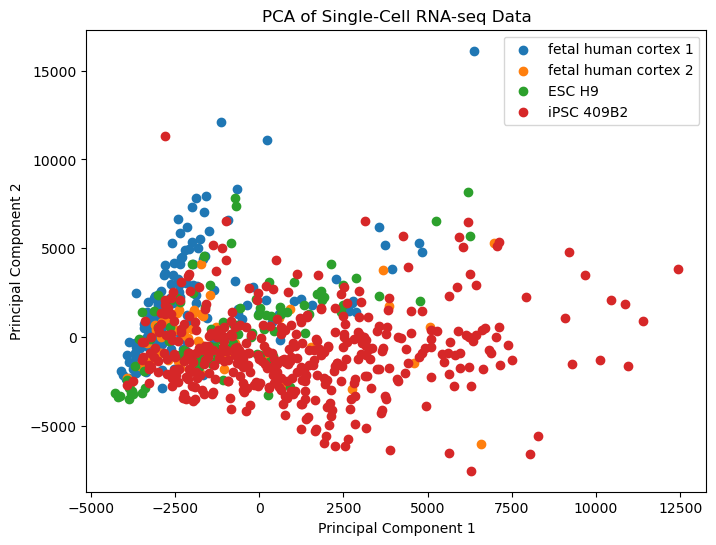

[0.10529254 0.07885465]


In [11]:
def pca_batches(expression_batches):
    
    '''
    '''
    # Perform PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(expression_batches.transpose())
    # Create a DataFrame with the PCA results
    pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'],
                          index = expression_batches.columns)
#     pca_df['Batch'] = expression_batches.columns

    # Plot the PCA results
    plt.figure(figsize=(8, 6))
    for batch in pca_df.index.unique():
        subset = pca_df[pca_df.index == batch]
        plt.scatter(subset['PC1'], subset['PC2'], label=batch)

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA of Single-Cell RNA-seq Data')
    plt.legend()
    plt.show()
    print(pca.explained_variance_ratio_)

    return 

pca_batches(expression_batched)

Species    ['Homo sapiens']
cell_type1    ['dosal cortex progenitor' 'Unknown' 'dosal cortex neuron' 'neuron'
 'mesenchyme' 'ventral progenitor']
Source    ['Fetal neocortex'
 'Microdissected cortical-like ventricle from cerebral organoid'
 'Dissociated whole cerebral organoid']
age    ['12 weeks post-conception' '13 weeks post-conception' '53 days' '58 days'
 '35 days' '37 days' '41 days' '65 days' '33 days']
batch    ['fetal human cortex 1' 'fetal human cortex 2' 'ESC H9' 'iPSC 409B2']


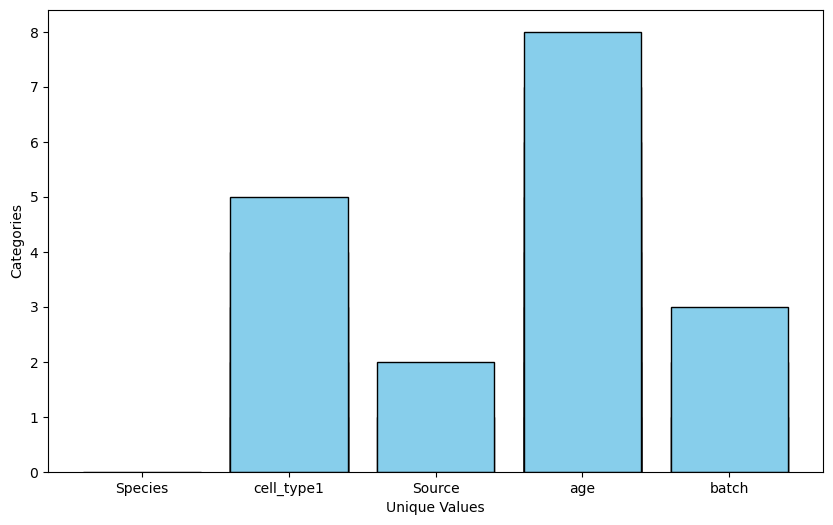

In [12]:
bar_plot = {}
for col in meta_data.columns:
  print(col + '   ', meta_data[col].unique())

  bar_plot[col]  = meta_data[col].unique()

# Plotting
plt.figure(figsize=(10, 6))

# For each key-value pair in the data, create a horizontal bar
for i, (key, values) in enumerate(bar_plot.items()):
    plt.bar([key]*len(values),range(len(values)), color="skyblue", edgecolor="black")

# Adding labels and title
plt.xlabel("Unique Values")
plt.ylabel("Categories")
plt.title("")
# plt.gca().invert_yaxis()  # Invert y-axis for better readability

# Show plot
plt.show()


# Preprocess Data

**Filter Out Low Quality Cells**
1. Low number of detected genes
2. Low count depth
3. High percentage of mitochondrial counts (dying cells with broken membranes)
4. Quality control is performed at the sample level as thresholds can vary substantially between samples.

**Filter Out Cells with Total log_reads < 16**

count       734.000000
mean     242772.974212
std       67357.469589
min       52215.441756
10%      168901.394288
15%      180252.396888
25%      199655.684762
50%      236101.406304
75%      281630.315542
max      473414.548435
dtype: float64


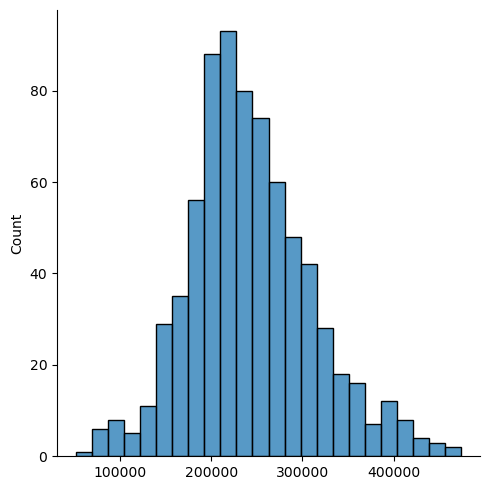

In [13]:
total_counts  = expression_data.sum(axis = 0)
print(total_counts.describe(percentiles = [0.10, 0.15, 0.25, 0.50, 0.75]))
sns.displot(total_counts)

count      734.000000
mean     15162.846049
std       1238.842663
min      11785.000000
25%      14224.750000
50%      15493.000000
75%      16100.250000
max      18074.000000
dtype: float64


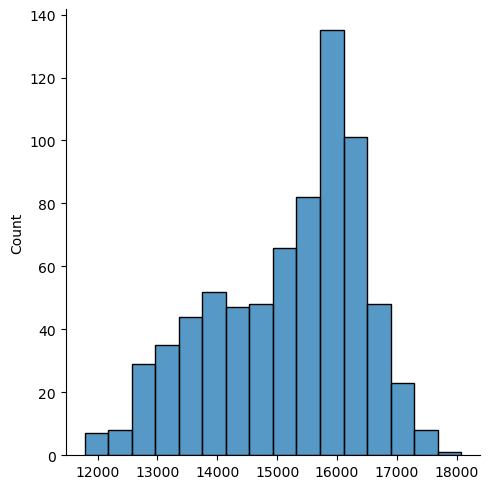

In [14]:
missing_genes = (expression_data == 0.0).sum(axis = 0)
print(missing_genes.describe())
sns.displot(missing_genes)

**Filter Out Cells with Low Number of Genes**
1. Total of 18900 genes in dataset
2. Filter out cells that are 2 std away from mean of genes (~17500 genes are missing or 1400 genes)
3. Filter out cells with less than 4000 counts

# Scanpy Workflow

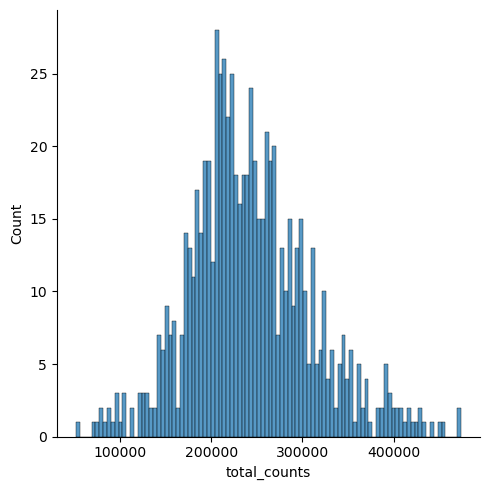

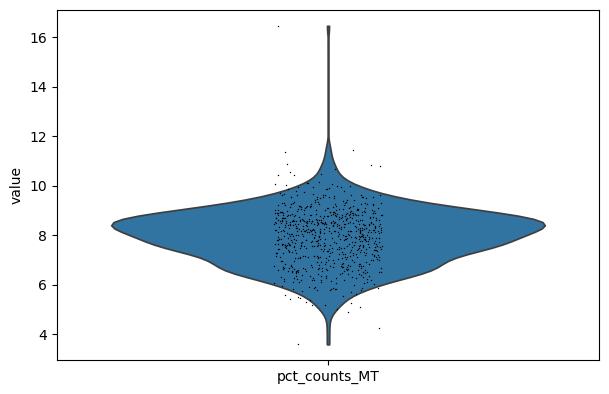

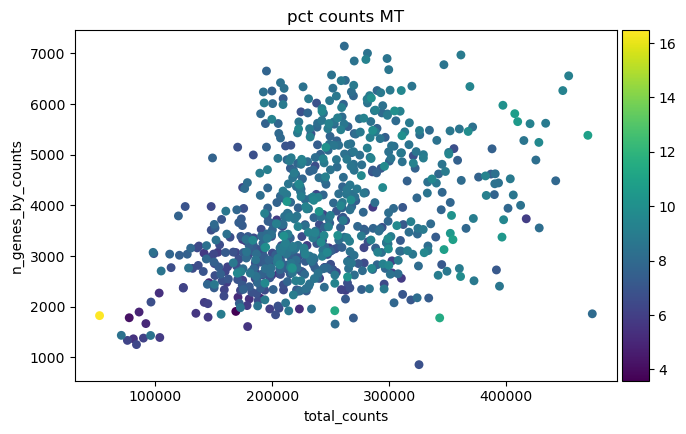

In [15]:
class ScanpyObject:

  # Data: Gene x Cell Row Matrix with Cells in index
  #       Columns Gene IDS correspond to the Columns

  # Leiden Groups: # of Groups for Clustering In Leiden Algorithm
  # Random State: The random seed introduced to Python for reproducability
  # PCA, UMAP, and TSNE utilitze a stochastic gradient algorithm (starting point matters)
  # PCA is determinsitic but due to the high rank of these datasets, "random PCA" may be used
  '''
  min_counts: The minimum counts needed for a cell to not be filtered out (low quality cells have low counts)
  '''
  # Metalables: Title of Column Describing Gene Categorization
  #             For example: mRNA, Protein coding, siRNA, etc.,

  def __init__(self,
               data,
               min_counts = None,
               leiden_groups = 15,
               random_state  = 42,
               percent_top   = 20, 
               metalabels    = 'protein_coding',
               log_data      = True,
               normalize     = True,
               plot_qc       = True,
               manual_filtering = False,
               target_sum    = 10000):

    self.log_data           = log_data
    self.data_object        = sc.AnnData(data.copy())
    self.data_highvar       = None
    self.leiden_gene_groups = leiden_groups   # TSNE Plots leiden groups
    self.random_state       = random_state    # Seed For Reproducability

    if normalize:
      sc.pp.normalize_total(self.data_object, target_sum = target_sum)

    if log_data:
      sc.pp.log1p(self.data_object)

    self._preprocess_workflow(metalabels, min_counts, percent_top, manual_filtering, plot_qc)
    
#     sc.pp.highly_variable_genes(self.data_object, min_mean=0.0125, max_mean=3, min_disp=0.5)

    # self._regress_highvar()
    # self._nearest_neighbors()
    # self._dimension_reduction()
    
    
  def is_outlier(self, adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier


  def _preprocess_workflow(self, metalabels, min_counts, percent_top, manual_filtering, plot_qc):
    
    # Initialize Variables Avoid Errors
    total_counts   = None
    n_genes_counts = None
    
    self._mitochondrial()
    self._calculate_qc_metrics(percent_top)
    if plot_qc:
        self.plot_qc()
        
    if manual_filtering and min_counts is not None:
        self._filter_cells(min_counts)
    
    else:
  
        total_counts   = 'total_counts'
        n_genes_counts = 'n_genes_by_counts'

        self.data_object.obs['outlier'] = (
        self.is_outlier(self.data_object, total_counts, 5)
        | self.is_outlier(self.data_object, n_genes_counts, 5)
        | self.is_outlier(self.data_object, f'pct_counts_in_top_{percent_top}_genes', 5)
        )
        
        self.data_object.obs["MT_outlier"] = self.is_outlier(self.data_object, "pct_counts_MT", 3) | (
        self.data_object.obs["pct_counts_MT"] > 8
        )

        
  def plot_qc(self):
    
    p1 = sns.displot(self.data_object.obs['total_counts'], bins=100, kde=False)
    # sc.pl.violin(adata, 'total_counts')
    p2 = sc.pl.violin(self.data_object, f'pct_counts_MT')
    p3 = sc.pl.scatter(self.data_object, 'total_counts', 'n_genes_by_counts', color='pct_counts_MT')
    
  def _mitochondrial(self, prefix = 'MT'):
    self.data_object.var[prefix] = self.data_object.var_names.str.startswith(prefix)
    
  def _filter_cells(self, min_counts):
    sc.pp.filter_cells(self.data_object, min_counts = min_counts)

  def _calculate_qc_metrics(self, percent_top):

    self.non_qc = ['highly_variable', 'means', 'dispersions', 'dispersions_norm']
    self.qc     = [col for col in self.data_object.var if col not in self.non_qc]
    
    sc.pp.calculate_qc_metrics(self.data_object, qc_vars=self.data_object.var[self.qc],
                                           percent_top=[percent_top], log1p=False, inplace=True)

  # Creates Another Object, With High Variability Genes Only
  def _regress_highvar(self):

    self.data_highvar  = self.data_object[:, self.data_object.var.highly_variable]
    sc.pp.regress_out(self.data_highvar, ['total_counts', 'pct_counts_Mt_rRNA'])

  # Leiden Clustering
  def _nearest_neighbors(self):
    sc.pp.neighbors(self.data_highvar, n_neighbors=10, n_pcs=40)
    sc.tl.leiden(self.data_highvar) # calculate the neighbors

  def _retreive_ranked_groups(self):
    gene_groups     = self.leiden_gene_groups
    gene_ranks_list = list(self.data_highvar.uns['rank_genes_groups']['names'])
    if len(gene_ranks_list) != 0:
      ranked_groups = gene_ranks_list[:gene_groups]

    return ranked_groups

  def _dimension_reduction(self):
    sc.pp.pca(self.data_highvar, svd_solver = 'arpack', random_state = self.random_state)
    sc.tl.pca(self.data_highvar, svd_solver = 'arpack')
    sc.tl.rank_genes_groups(self.data_highvar, 'leiden', method='t-test')


  # def _attach_metalabels(self, metalabels):
    # for metalabel in ids[metalabels].unique():
    #   self.data_object.var[metalabel] = self.data_object.var_names.str.startswith(metalabel)

  def leiden_ranking(self):
    sc.pl.rank_genes_groups(self.data_highvar, n_genes=self.leiden_gene_groups, sharey=False)

  def marker_genes(self):
    markers       = 2
    ranked_groups = self._retreive_ranked_groups()
    top_ranked    = {value: list(ranked_groups[value])[0:markers] for value in range(len(ranked_groups))}

    return top_ranked

  # -------------------------------------------------------------------------------------
  # Plot UMAP Takes The Highest Rank Marker Gene and Plots with UMAP
  # UMAP (Unifold Manifold) is a technique that aims to separate similar groups
  # UMAP is purely a visual technqiue, meaning the axes have no meaning
  # Separation does indicate that the groups are similar, but not as interpretable as PCA

  def plot_umap(self, color_type = 'highly_variable'):
    highly_variable = self.marker_genes()
    highly_variable = list(highly_variable.values())
    highly_variable = [gene[0] for gene in highly_variable]

    # # highly_variable = ['ENSG00000001561', 'ENSG00000286231']
    sc.tl.paga(self.data_highvar)
    sc.pl.paga(self.data_highvar, plot     =  False)  # remove `plot=False` if you want to see the coarse-grained graph
    sc.tl.umap(self.data_highvar, init_pos = 'paga')

    if color_type == 'highly_variable':
      sc.pl.umap(self.data_highvar, color=highly_variable)
    else:
      sc.pl.umap(self.data_highvar, color = color_type)

  def pca(self, gene_id = 'ENSG00000283761'):
    sc.pl.pca(self.data_highvar, color = gene_id, annotate_var_explained = True)

  def plot_high_expr(self):
    sc.pl.highest_expr_genes(self.data_object, n_top = 20)

  def plot_tsne(self):
    sc.tl.tsne(self.data_highvar, use_rep = 'X_pca')
    sc.pl.tsne(self.data_highvar, color=["leiden"], cmap="tab20")

  def scatter_plots(self):
    if not self.data_object.var.empty:
      total_plots = len(self.data_object.var.columns)
      fig, ax     = plt.subplots(8,5, figsize=(40,24))
      row         = 0
      col         = 0
      for plot in range(total_plots):
          protein_type = str(self.data_object.var.columns[plot])
          try:
            sc.pl.scatter(self.data_object, x='total_counts',
                          y = 'pct_counts_' + protein_type, ax = ax[row, col], show = False)
          # Deal with ax[row, col] calling for

          # Total Counts, n_genes_counts, etc
          except ValueError:
            col -= 1     # Counter Col += 1 Count


          col += 1
          if col > 4:
              row += 1
              col = 0
    else:
      raise ValueError(f'''{self.data_object.var} does not contain any data. Preprocess
      metalabels to receive scatter plots''')

  def plot_highly_variable(self):
    sc.pl.highly_variable_genes(self.data_object)

  def plot_pca_variance_ratio(self):
    sc.pl.pca_variance_ratio(self.data_highvar, log=True)


# Mitochondrial Genes Look Good
# Total count depth looks good for all genes
# Filtering with is_outlier function keeps all data
# Data may have been filtered already

min_counts  = expression_data.sum(axis = 1).describe()['min'] # 16^2 (256 counts) lots of cells have 0
scanpy_obj1 = ScanpyObject(expression_data.transpose(),
                           min_counts       = min_counts, 
                           log_data         = False, 
                           normalize        = False, 
                           percent_top      = 20,
                           manual_filtering = False)     # meta indexes data
# scanpy_obj2 = ScanpyObject(data_obj) # original indexes data

adata     = scanpy_obj1.data_object

In [16]:
import anndata2ri
import logging

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

# Only Errors from R will be Displayed
rcb.logger.setLevel(logging.ERROR)

# Allows for Dataframe Conversion from R and Pandas seamlessly
ro.pandas2ri.activate()

# Allows for Anndata conversion to R seamlesleslly
# anndata2ri.activate()

# Magic command to load the R jupyter notebooks extension with python
%load_ext rpy2.ipython
# %reload_ext rpy2.ipython

**`Add Necessary Permissions for R to write to R package location**

In [ ]:
# Download in terminal
# sudo apt-get update && sudo apt-get install libopenblas-dev

In [17]:
!sudo chmod -R 777 /usr/lib/R/site-library /usr/lib/R/library /usr/local/lib/R/site-library

^C


**If Error lock something something happens excute the following**
1. rm -rf /home/sagemaker-user/R/x86_64-pc-linux-gnu-library/4.1/00LOCK-Matrix


In [18]:
%%R
cran <- "http://cran.us.r-project.org"
lib  <- '/home/sagemaker-user/R/x86_64-pc-linux-gnu-library/4.1'

remotes::install_version('Matrix', version = '1.6-1.1', repos = cran)
remotes::install_version('SeuratObject', version = '4.1.4', repos = cran, lib = lib)
remotes::install_version("Seurat", version = "4.4.0", repos = cran, lib = lib)

* installing *source* package ‘Matrix’ ...
** package ‘Matrix’ successfully unpacked and MD5 sums checked
** using staged installation
** libs


gcc -I"/usr/share/R/include" -DNDEBUG -DNTIMER -I./SuiteSparse_config -DUSE_FC_LEN_T     -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c CHMfactor.c -o CHMfactor.o
gcc -I"/usr/share/R/include" -DNDEBUG -DNTIMER -I./SuiteSparse_config -DUSE_FC_LEN_T     -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c Csparse.c -o Csparse.o
gcc -I"/usr/share/R/include" -DNDEBUG -DNTIMER -I./SuiteSparse_config -DUSE_FC_LEN_T     -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c init.c -o init.o
gcc -I"/usr/share/R/include" -DNDEBUG -DNTIMER -I./SuiteSparse_config -DUSE_FC_LEN_T     -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protec

ar: `u' modifier ignored since `D' is the default (see `U')


gcc -I"/usr/share/R/include" -DNDEBUG -I../Include -I../../SuiteSparse_config     -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -I../Include -DDLONG -c colamd.c -o colamd_l.o
ar -rucs ../../COLAMD.a colamd.o colamd_l.o
make[2]: Leaving directory '/tmp/Rtmp2SQ8kK/remotes1b878a970f9/Matrix/src/COLAMD/Source'
make[1]: Leaving directory '/tmp/Rtmp2SQ8kK/remotes1b878a970f9/Matrix/src/COLAMD'
make[1]: Entering directory '/tmp/Rtmp2SQ8kK/remotes1b878a970f9/Matrix/src/AMD'
( cd Source ; make -f "/usr/lib/R/etc/Makeconf" -f Makefile lib )
make[2]: Entering directory '/tmp/Rtmp2SQ8kK/remotes1b878a970f9/Matrix/src/AMD/Source'
gcc -I"/usr/share/R/include" -DNDEBUG -I../Include -I../../SuiteSparse_config     -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -I../Include -DDI

ar: `u' modifier ignored since `D' is the default (see `U')


gcc -I"/usr/share/R/include" -DNDEBUG -I../Include -I../../SuiteSparse_config     -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -I../Include -DDLONG -c amd_1.c -o amd_l_1.o
gcc -I"/usr/share/R/include" -DNDEBUG -I../Include -I../../SuiteSparse_config     -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -I../Include -DDINT -c amd_2.c -o amd_i_2.o
gcc -I"/usr/share/R/include" -DNDEBUG -I../Include -I../../SuiteSparse_config     -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -I../Include -DDLONG -c amd_2.c -o amd_l_2.o
gcc -I"/usr/share/R/include" -DNDEBUG -I../Include -I../../SuiteSparse_config     -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg

ar: `u' modifier ignored since `D' is the default (see `U')
ar: `u' modifier ignored since `D' is the default (see `U')
installing to /home/sagemaker-user/R/x86_64-pc-linux-gnu-library/4.1/00LOCK-Matrix/00new/Matrix/libs
** R
** data
** inst
** byte-compile and prepare package for lazy loading


Creating a generic function for ‘zapsmall’ from package ‘base’ in package ‘Matrix’
Creating a generic function for ‘unname’ from package ‘base’ in package ‘Matrix’
Creating a generic function for ‘drop’ from package ‘base’ in package ‘Matrix’
in method for ‘coerce’ with signature ‘"matrix.csc","dgCMatrix"’: no definition for class “matrix.csc”
in method for ‘coerce’ with signature ‘"matrix.csr","dgRMatrix"’: no definition for class “matrix.csr”
in method for ‘coerce’ with signature ‘"matrix.coo","dgTMatrix"’: no definition for class “matrix.coo”
in method for ‘coerce’ with signature ‘"matrix.csr","dgCMatrix"’: no definition for class “matrix.csr”
in method for ‘coerce’ with signature ‘"matrix.coo","dgCMatrix"’: no definition for class “matrix.coo”
in method for ‘coerce’ with signature ‘"matrix.csc","CsparseMatrix"’: no definition for class “matrix.csc”
in method for ‘coerce’ with signature ‘"matrix.csc","RsparseMatrix"’: no definition for class “matrix.csc”
in method for ‘coerce’ with 

** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (Matrix)
* installing *source* package ‘SeuratObject’ ...
** package ‘SeuratObject’ successfully unpacked and MD5 sums checked
** using staged installation
** libs


g++ -std=gnu++14 -I"/usr/share/R/include" -DNDEBUG  -I'/usr/local/lib/R/site-library/Rcpp/include' -I'/usr/local/lib/R/site-library/RcppEigen/include'    -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c RcppExports.cpp -o RcppExports.o


In file included from /usr/local/lib/R/site-library/RcppEigen/include/Eigen/Core:205,
                 from /usr/local/lib/R/site-library/RcppEigen/include/Eigen/Dense:1,
                 from /usr/local/lib/R/site-library/RcppEigen/include/RcppEigenForward.h:28,
                 from /usr/local/lib/R/site-library/RcppEigen/include/RcppEigen.h:25,
                 from RcppExports.cpp:4:
/usr/local/lib/R/site-library/RcppEigen/include/Eigen/src/Core/arch/SSE/PacketMath.h:46:40: warning: ignoring attributes on template argument ‘__m128i’ [-Wignored-attributes]
   46 | typedef eigen_packet_wrapper<__m128i, 0> Packet4i;
      |                                        ^
/usr/local/lib/R/site-library/RcppEigen/include/Eigen/src/Core/arch/SSE/PacketMath.h:47:40: warning: ignoring attributes on template argument ‘__m128i’ [-Wignored-attributes]
   47 | typedef eigen_packet_wrapper<__m128i, 1> Packet16b;
      |                                        ^
/usr/local/lib/R/site-library/RcppEigen/in

g++ -std=gnu++14 -I"/usr/share/R/include" -DNDEBUG  -I'/usr/local/lib/R/site-library/Rcpp/include' -I'/usr/local/lib/R/site-library/RcppEigen/include'    -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c data_manipulation.cpp -o data_manipulation.o


In file included from /usr/local/lib/R/site-library/RcppEigen/include/Eigen/Core:205,
                 from /usr/local/lib/R/site-library/RcppEigen/include/Eigen/Dense:1,
                 from /usr/local/lib/R/site-library/RcppEigen/include/RcppEigenForward.h:28,
                 from /usr/local/lib/R/site-library/RcppEigen/include/RcppEigen.h:25,
                 from data_manipulation.cpp:1:
/usr/local/lib/R/site-library/RcppEigen/include/Eigen/src/Core/arch/SSE/PacketMath.h:46:40: warning: ignoring attributes on template argument ‘__m128i’ [-Wignored-attributes]
   46 | typedef eigen_packet_wrapper<__m128i, 0> Packet4i;
      |                                        ^
/usr/local/lib/R/site-library/RcppEigen/include/Eigen/src/Core/arch/SSE/PacketMath.h:47:40: warning: ignoring attributes on template argument ‘__m128i’ [-Wignored-attributes]
   47 | typedef eigen_packet_wrapper<__m128i, 1> Packet16b;
      |                                        ^
/usr/local/lib/R/site-library/RcppEi

gcc -I"/usr/share/R/include" -DNDEBUG  -I'/usr/local/lib/R/site-library/Rcpp/include' -I'/usr/local/lib/R/site-library/RcppEigen/include'    -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c valid_pointer.c -o valid_pointer.o
g++ -std=gnu++14 -shared -L/usr/lib/R/lib -Wl,-Bsymbolic-functions -flto=auto -ffat-lto-objects -flto=auto -Wl,-z,relro -o SeuratObject.so RcppExports.o data_manipulation.o valid_pointer.o -L/usr/lib/R/lib -lR


installing to /home/sagemaker-user/R/x86_64-pc-linux-gnu-library/4.1/00LOCK-SeuratObject/00new/SeuratObject/libs
** R
** data
*** moving datasets to lazyload DB
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (SeuratObject)


These packages have more recent versions available.
It is recommended to update all of them.
Which would you like to update?

1: All                                   
2: CRAN packages only                    
3: None                                  
4: caTools      (1.18.2 -> 1.18.3) [CRAN]
5: reticulate   (1.38.0 -> 1.39.0) [CRAN]
6: SeuratObject (4.1.4  -> 5.0.2 ) [CRAN]
7: ggrepel      (0.9.5  -> 0.9.6 ) [CRAN]



* installing *source* package ‘Seurat’ ...
** package ‘Seurat’ successfully unpacked and MD5 sums checked
** using staged installation
** libs


g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG  -I'/usr/local/lib/R/site-library/Rcpp/include' -I'/usr/local/lib/R/site-library/RcppEigen/include' -I'/usr/local/lib/R/site-library/RcppProgress/include'    -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c ModularityOptimizer.cpp -o ModularityOptimizer.o
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG  -I'/usr/local/lib/R/site-library/Rcpp/include' -I'/usr/local/lib/R/site-library/RcppEigen/include' -I'/usr/local/lib/R/site-library/RcppProgress/include'    -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c RModularityOptimizer.cpp -o RModularityOptimizer.o


In file included from /usr/local/lib/R/site-library/RcppEigen/include/Eigen/Core:205,
                 from /usr/local/lib/R/site-library/RcppEigen/include/Eigen/Dense:1,
                 from /usr/local/lib/R/site-library/RcppEigen/include/RcppEigenForward.h:28,
                 from /usr/local/lib/R/site-library/RcppEigen/include/RcppEigen.h:25,
                 from RModularityOptimizer.cpp:9:
/usr/local/lib/R/site-library/RcppEigen/include/Eigen/src/Core/arch/SSE/PacketMath.h:46:40: warning: ignoring attributes on template argument ‘__m128i’ [-Wignored-attributes]
   46 | typedef eigen_packet_wrapper<__m128i, 0> Packet4i;
      |                                        ^
/usr/local/lib/R/site-library/RcppEigen/include/Eigen/src/Core/arch/SSE/PacketMath.h:47:40: warning: ignoring attributes on template argument ‘__m128i’ [-Wignored-attributes]
   47 | typedef eigen_packet_wrapper<__m128i, 1> Packet16b;
      |                                        ^
/usr/local/lib/R/site-library/Rcp

g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG  -I'/usr/local/lib/R/site-library/Rcpp/include' -I'/usr/local/lib/R/site-library/RcppEigen/include' -I'/usr/local/lib/R/site-library/RcppProgress/include'    -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c RcppExports.cpp -o RcppExports.o


In file included from /usr/local/lib/R/site-library/RcppEigen/include/Eigen/Core:205,
                 from /usr/local/lib/R/site-library/RcppEigen/include/Eigen/Dense:1,
                 from /usr/local/lib/R/site-library/RcppEigen/include/RcppEigenForward.h:28,
                 from /usr/local/lib/R/site-library/RcppEigen/include/RcppEigen.h:25,
                 from RcppExports.cpp:4:
/usr/local/lib/R/site-library/RcppEigen/include/Eigen/src/Core/arch/SSE/PacketMath.h:46:40: warning: ignoring attributes on template argument ‘__m128i’ [-Wignored-attributes]
   46 | typedef eigen_packet_wrapper<__m128i, 0> Packet4i;
      |                                        ^
/usr/local/lib/R/site-library/RcppEigen/include/Eigen/src/Core/arch/SSE/PacketMath.h:47:40: warning: ignoring attributes on template argument ‘__m128i’ [-Wignored-attributes]
   47 | typedef eigen_packet_wrapper<__m128i, 1> Packet16b;
      |                                        ^
/usr/local/lib/R/site-library/RcppEigen/in

g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG  -I'/usr/local/lib/R/site-library/Rcpp/include' -I'/usr/local/lib/R/site-library/RcppEigen/include' -I'/usr/local/lib/R/site-library/RcppProgress/include'    -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c data_manipulation.cpp -o data_manipulation.o


In file included from /usr/local/lib/R/site-library/RcppEigen/include/Eigen/Core:205,
                 from /usr/local/lib/R/site-library/RcppEigen/include/Eigen/Dense:1,
                 from /usr/local/lib/R/site-library/RcppEigen/include/RcppEigenForward.h:28,
                 from /usr/local/lib/R/site-library/RcppEigen/include/RcppEigen.h:25,
                 from data_manipulation.cpp:1:
/usr/local/lib/R/site-library/RcppEigen/include/Eigen/src/Core/arch/SSE/PacketMath.h:46:40: warning: ignoring attributes on template argument ‘__m128i’ [-Wignored-attributes]
   46 | typedef eigen_packet_wrapper<__m128i, 0> Packet4i;
      |                                        ^
/usr/local/lib/R/site-library/RcppEigen/include/Eigen/src/Core/arch/SSE/PacketMath.h:47:40: warning: ignoring attributes on template argument ‘__m128i’ [-Wignored-attributes]
   47 | typedef eigen_packet_wrapper<__m128i, 1> Packet16b;
      |                                        ^
/usr/local/lib/R/site-library/RcppEi

g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG  -I'/usr/local/lib/R/site-library/Rcpp/include' -I'/usr/local/lib/R/site-library/RcppEigen/include' -I'/usr/local/lib/R/site-library/RcppProgress/include'    -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c fast_NN_dist.cpp -o fast_NN_dist.o
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG  -I'/usr/local/lib/R/site-library/Rcpp/include' -I'/usr/local/lib/R/site-library/RcppEigen/include' -I'/usr/local/lib/R/site-library/RcppProgress/include'    -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c integration.cpp -o integration.o


In file included from /usr/local/lib/R/site-library/RcppEigen/include/Eigen/Core:205,
                 from /usr/local/lib/R/site-library/RcppEigen/include/Eigen/Dense:1,
                 from /usr/local/lib/R/site-library/RcppEigen/include/RcppEigenForward.h:28,
                 from /usr/local/lib/R/site-library/RcppEigen/include/RcppEigen.h:25,
                 from integration.cpp:1:
/usr/local/lib/R/site-library/RcppEigen/include/Eigen/src/Core/arch/SSE/PacketMath.h:46:40: warning: ignoring attributes on template argument ‘__m128i’ [-Wignored-attributes]
   46 | typedef eigen_packet_wrapper<__m128i, 0> Packet4i;
      |                                        ^
/usr/local/lib/R/site-library/RcppEigen/include/Eigen/src/Core/arch/SSE/PacketMath.h:47:40: warning: ignoring attributes on template argument ‘__m128i’ [-Wignored-attributes]
   47 | typedef eigen_packet_wrapper<__m128i, 1> Packet16b;
      |                                        ^
/usr/local/lib/R/site-library/RcppEigen/in

g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG  -I'/usr/local/lib/R/site-library/Rcpp/include' -I'/usr/local/lib/R/site-library/RcppEigen/include' -I'/usr/local/lib/R/site-library/RcppProgress/include'    -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c snn.cpp -o snn.o


In file included from /usr/local/lib/R/site-library/RcppEigen/include/Eigen/Core:205,
                 from /usr/local/lib/R/site-library/RcppEigen/include/Eigen/Dense:1,
                 from /usr/local/lib/R/site-library/RcppEigen/include/RcppEigenForward.h:28,
                 from /usr/local/lib/R/site-library/RcppEigen/include/RcppEigen.h:25,
                 from snn.cpp:1:
/usr/local/lib/R/site-library/RcppEigen/include/Eigen/src/Core/arch/SSE/PacketMath.h:46:40: warning: ignoring attributes on template argument ‘__m128i’ [-Wignored-attributes]
   46 | typedef eigen_packet_wrapper<__m128i, 0> Packet4i;
      |                                        ^
/usr/local/lib/R/site-library/RcppEigen/include/Eigen/src/Core/arch/SSE/PacketMath.h:47:40: warning: ignoring attributes on template argument ‘__m128i’ [-Wignored-attributes]
   47 | typedef eigen_packet_wrapper<__m128i, 1> Packet16b;
      |                                        ^
/usr/local/lib/R/site-library/RcppEigen/include/Ei

g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG  -I'/usr/local/lib/R/site-library/Rcpp/include' -I'/usr/local/lib/R/site-library/RcppEigen/include' -I'/usr/local/lib/R/site-library/RcppProgress/include'    -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c stats.cpp -o stats.o
gcc -I"/usr/share/R/include" -DNDEBUG  -I'/usr/local/lib/R/site-library/Rcpp/include' -I'/usr/local/lib/R/site-library/RcppEigen/include' -I'/usr/local/lib/R/site-library/RcppProgress/include'    -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c valid_pointer.c -o valid_pointer.o
g++ -std=gnu++17 -shared -L/usr/lib/R/lib -Wl,-Bsymbolic-functions -flto=auto -ffat-lto-objects -flto=auto -Wl,-z,relro -o Seurat.so ModularityOptimizer.o RModularityOptimizer.o RcppExports.o data_manipulation

installing to /home/sagemaker-user/R/x86_64-pc-linux-gnu-library/4.1/00LOCK-Seurat/00new/Seurat/libs
** R
** data
*** moving datasets to lazyload DB
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (Seurat)


Installing package into ‘/home/sagemaker-user/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)
In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages


In [19]:
%%R 
install.packages('SoupX')
# library(SoupX)

* installing *source* package ‘SoupX’ ...
** package ‘SoupX’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** data
*** moving datasets to lazyload DB
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (SoupX)


Installing package into ‘/home/sagemaker-user/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)
trying URL 'https://cloud.r-project.org/src/contrib/SoupX_1.6.2.tar.gz'
Content type 'application/x-gzip' length 4962415 bytes (4.7 MB)
downloaded 4.7 MB


The downloaded source packages are in
	‘/tmp/Rtmp2SQ8kK/downloaded_packages’


**Use Update command if this fails**

In [20]:
%%R
library(SingleCellExperiment)
library(Seurat)
library(scater)
library(scDblFinder)
library(BiocParallel)
library(SoupX)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: ‘MatrixGenerics’

The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges, ro

# Actual R Workflow 
---

In [21]:
data_matrix = scanpy_obj1.data_object.X.T

**Identify Doublets in the dataset**

In [22]:
%%R -i data_matrix -o doublet_score -o doublet_class

set.seed(123)
sce = scDblFinder(
    SingleCellExperiment(
        list(counts=data_matrix),
    ) 
)

doublet_score = sce$scDblFinder.score
doublet_class = sce$scDblFinder.class

Creating ~5000 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 4 cells excluded from training.
iter=1, 12 cells excluded from training.
iter=2, 13 cells excluded from training.
Threshold found:0.907
12 (1.6%) doublets called


In [23]:
adata.obs["scDblFinder_score"] = doublet_score
adata.obs["scDblFinder_class"] = doublet_class
adata.obs.scDblFinder_class.value_counts()

scDblFinder_class
singlet    722
doublet     12
Name: count, dtype: int64

**Chapter 7: Gene Normalization Techniques**

In [24]:
sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    # color_map="YlGnBu",
    frameon=False,
)

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

/tmp/ipykernel_440/1495493670.py:11: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [25]:
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
# log1p transform
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

**Normalize Total Counts and log the data**

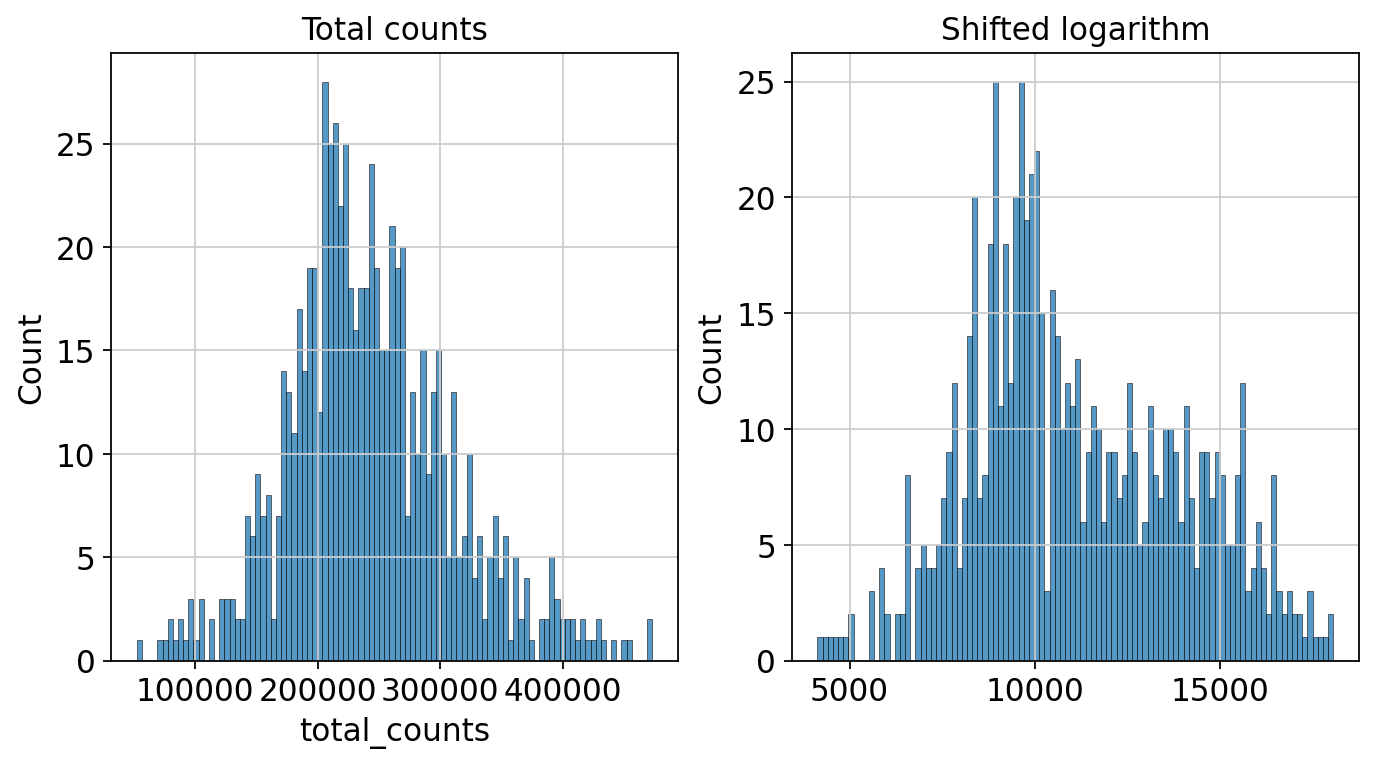

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()

In [27]:
from scipy.sparse import csr_matrix, issparse

In [28]:
%%R
library(scran)
library(BiocParallel)

**SCRAN normalization with Size Factors**

In [29]:
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="groups")

2024-09-08 18:43:39.901383: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/tmp/ipykernel_440/2253560473.py:6: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_pp, key_added="groups")


In [30]:
data_mat = adata_pp.X.T
# convert to CSC if possible. See https://github.com/MarioniLab/scran/issues/70

# Convert to sparse
if issparse(data_mat):
    # Less than 32bits
    if data_mat.nnz > 2**31 - 1:
        data_mat = data_mat.tocoo()
    else:
        data_mat = data_mat.tocsc()


ro.globalenv["data_mat"]        = data_mat
ro.globalenv["input_groups"]    = adata_pp.obs["groups"]

In [31]:
%%R -o size_factors

size_factors = sizeFactors(
    computeSumFactors(
        SingleCellExperiment(
            list(counts=data_mat)), 
            clusters = input_groups,
            min.mean = 0.1,
            BPPARAM  = MulticoreParam()
    )
)




In [32]:
adata.obs['Size Factors'] = size_factors
scran_normalized = adata.X / adata.obs['Size Factors'].values[:, None]
adata.layers["scran_normalization"]     = csr_matrix(sc.pp.log1p(scran_normalized))


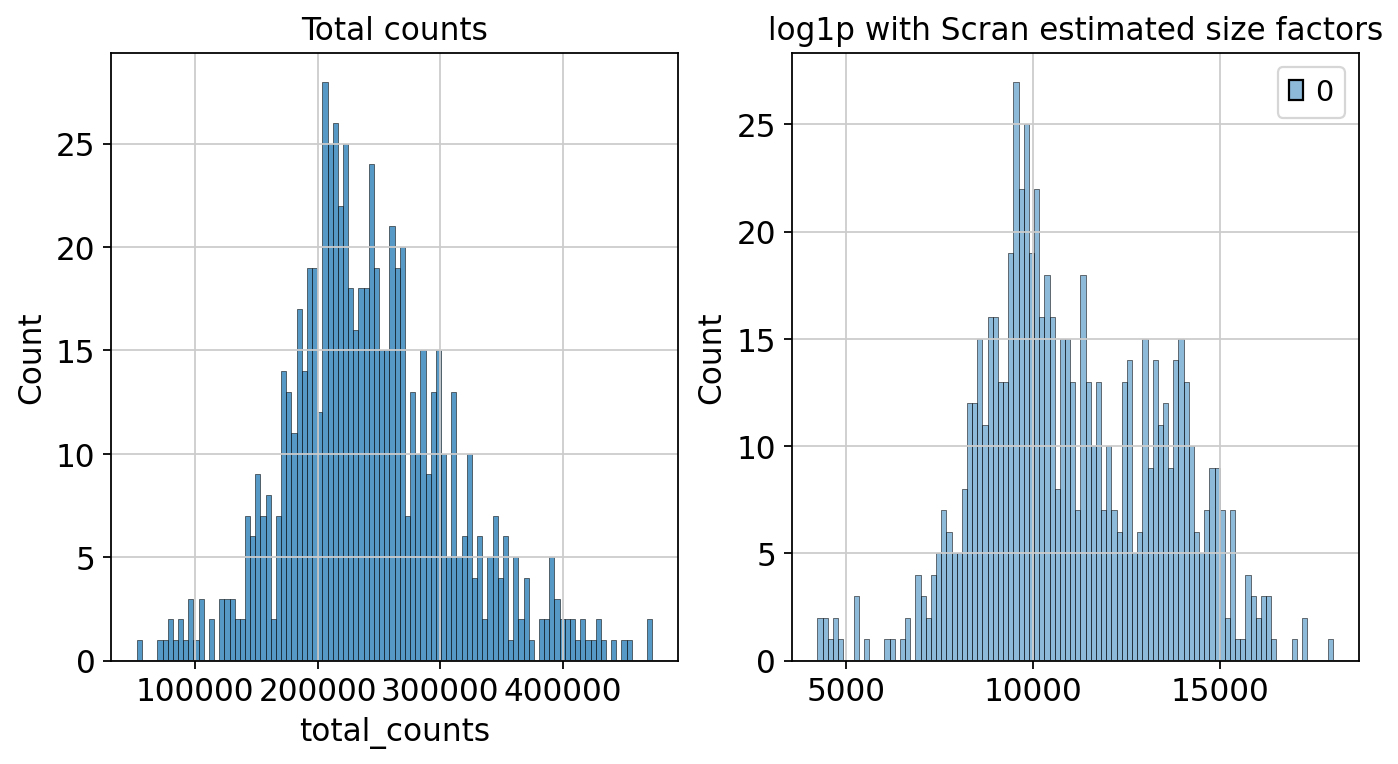

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(
    adata.layers["scran_normalization"].sum(1), bins=100, kde=False, ax=axes[1]
)
axes[1].set_title("log1p with Scran estimated size factors")
plt.show()

**Analyitc Pearson Residuals**

In [34]:
analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(adata, inplace=False)
adata.layers["analytic_pearson_residuals"] = csr_matrix(analytic_pearson["X"])

/opt/conda/lib/python3.10/site-packages/scanpy/experimental/pp/_normalization.py:54: UserWarning: `normalize_pearson_residuals()` expects raw count data, but non-integers were found.
  warn(
/opt/conda/lib/python3.10/site-packages/scanpy/experimental/pp/_normalization.py:70: RuntimeWarning: invalid value encountered in divide
  residuals = diff / np.sqrt(mu + mu**2 / theta)


Text(0.5, 1.0, 'Analytic Pearson residuals')

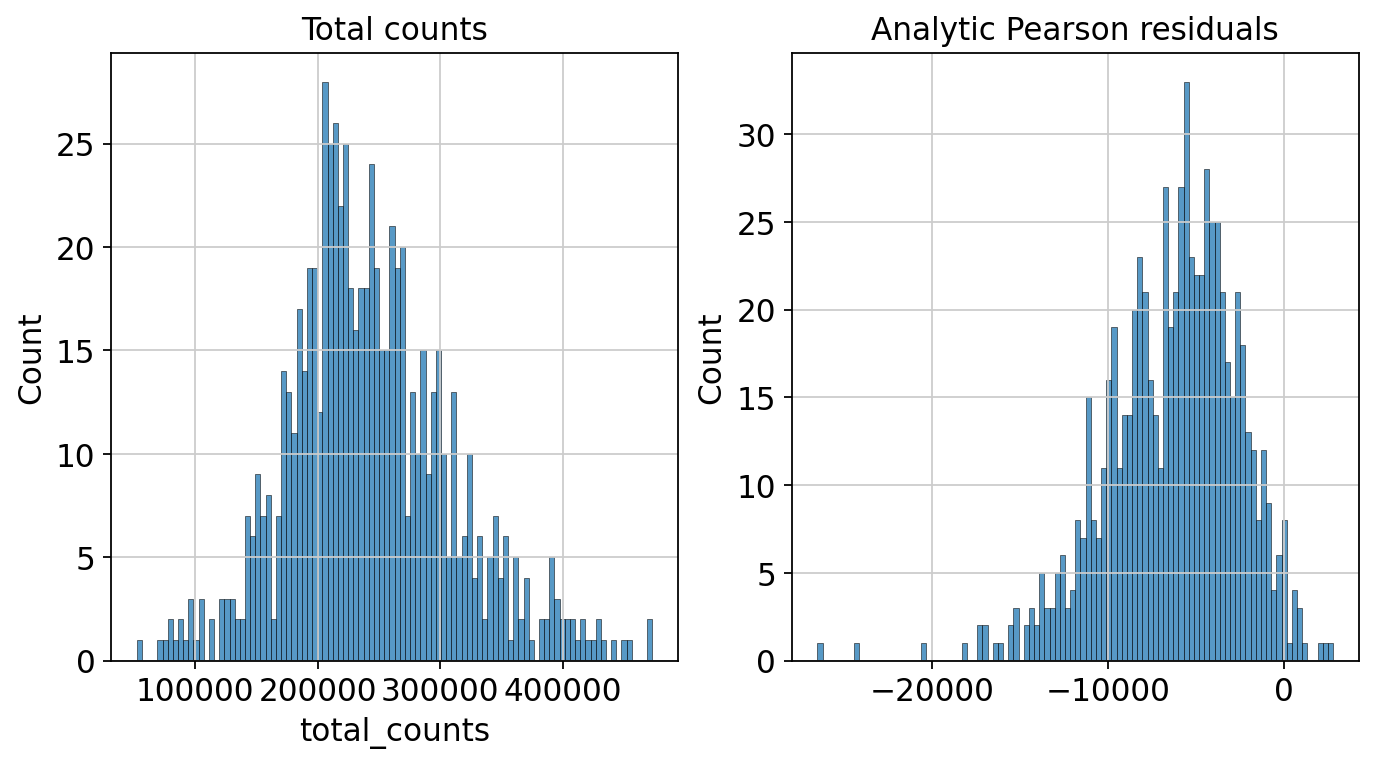

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
pearson_residuals = pd.DataFrame(adata.layers["analytic_pearson_residuals"].todense()).sum(axis = 1)
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(
    pearson_residuals, bins=100, kde=False, ax=axes[1]
)
axes[1].set_title("Analytic Pearson residuals")

In [51]:
ro.globalenv["adata"] = adata

In [47]:
%%R
BiocManager::install('scry')
library(scry)


* installing *source* package ‘Rhdf5lib’ ...
** using staged installation


checking for gcc... gcc
checking whether the C compiler works... yes
checking for C compiler default output file name... a.out
checking for suffix of executables... 
checking whether we are cross compiling... no
checking for suffix of object files... o
checking whether we are using the GNU C compiler... yes
checking whether gcc accepts -g... yes
checking for gcc option to accept ISO C89... none needed
checking whether we are using the GNU C++ compiler... yes
checking whether g++ -std=gnu++14 accepts -g... yes
COMPILER = gcc
checking whether C++ compiler accepts -Wno-unused-variable -Wno-unused-parameter... yes
checking whether C++ compiler accepts -Wno-cast-qual... yes
checking whether C++ compiler accepts -Wno-pedantic -Wno-extra... yes
checking whether C++ compiler accepts -Wno-format-overflow -Wno-format-truncation... yes
checking whether C++ compiler accepts -Wno-stringop-overflow -Wno-overlength-strings -Wno-stringop-truncation... yes
checking how to run the C++ preprocessor... g+

./configure: line 6829: /usr/bin/file: No such file or directory


yes
checking for sys/stat.h... yes
checking for stdlib.h... yes
checking for string.h... yes
checking for memory.h... yes
checking for strings.h... yes
checking for inttypes.h... yes
checking for stdint.h... yes
checking for unistd.h... yes
checking for dlfcn.h... yes
checking for objdir... .libs
checking if gcc supports -fno-rtti -fno-exceptions... no
checking for gcc option to produce PIC... -fPIC -DPIC
checking if gcc PIC flag -fPIC -DPIC works... yes
checking if gcc static flag -static works... yes
checking if gcc supports -c -o file.o... yes
checking if gcc supports -c -o file.o... (cached) yes
checking whether the gcc linker (/usr/bin/ld) supports shared libraries... yes
checking dynamic linker characteristics... GNU/Linux ld.so
checking how to hardcode library paths into programs... immediate
checking for shl_load... no
checking for shl_load in -ldld... no
checking for dlopen... yes
checking whether a program can dlopen itself... yes
checking whether a statically linked program 

rice.c:106:1: warning: function declaration isn't a prototype [-Wstrict-prototypes]
  106 | static int (*winner_function)();
      | ^~~~~~
rice.c:107:1: warning: function declaration isn't a prototype [-Wstrict-prototypes]
  107 | static int (*winner_ref_function)();
      | ^~~~~~
rice.c:301:1: warning: function declaration isn't a prototype [-Wstrict-prototypes]
  301 | getch()
      | ^~~~~
rice.c:333:1: warning: function declaration isn't a prototype [-Wstrict-prototypes]
  333 | read_header()
      | ^~~~~~~~~~~
rice.c: In function 'read_header':
rice.c:340:13: warning: conversion to 'long unsigned int' from 'int' may change the sign of the result [-Wsign-conversion]
  340 |     value = getch();
      |             ^~~~~
rice.c:341:26: warning: conversion to 'long unsigned int' from 'int' may change the sign of the result [-Wsign-conversion]
  341 |     value = (value << 8) | getch();
      |                          ^
rice.c:355:30: warning: conversion to 'long unsigned int' fro

mv -f .deps/rice.Tpo .deps/rice.Plo
/bin/bash ../libtool  --tag=CC   --mode=compile gcc -DHAVE_CONFIG_H -I.     -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -Wno-unused-variable -Wno-unused-parameter -Wno-cast-qual -Wno-pedantic -Wno-extra -Wno-format-overflow -Wno-format-truncation -Wno-stringop-overflow -Wno-overlength-strings -Wno-stringop-truncation -fpic -ansi -pedantic -Wall -W -Wundef -Wshadow -Wpointer-arith -Wbad-function-cast -Wcast-qual -Wcast-align -Wwrite-strings -Wconversion -Wsign-compare -Waggregate-return -Wstrict-prototypes -Wmissing-prototypes -Wmissing-declarations -Wredundant-decls -Wnested-externs -Winline -O -fomit-frame-pointer -finline-functions -MT sz_api.lo -MD -MP -MF .deps/sz_api.Tpo -c -o sz_api.lo sz_api.c
libtool: compile:  gcc -DHAVE_CONFIG_H -I. -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-

sz_api.c:47:6: warning: redundant redeclaration of 'szip_compress_memory' [-Wredundant-decls]
   47 | long szip_compress_memory(
      |      ^~~~~~~~~~~~~~~~~~~~
In file included from szlib.h:42,
                 from sz_api.c:45:
ricehdf.h:62:6: note: previous declaration of 'szip_compress_memory' with type 'long int(int,  int,  int,  int,  const void *, long int,  char *)'
   62 | long szip_compress_memory(
      |      ^~~~~~~~~~~~~~~~~~~~
sz_api.c:56:6: warning: redundant redeclaration of 'szip_uncompress_memory' [-Wredundant-decls]
   56 | long szip_uncompress_memory(
      |      ^~~~~~~~~~~~~~~~~~~~~~
In file included from szlib.h:42,
                 from sz_api.c:45:
ricehdf.h:71:6: note: previous declaration of 'szip_uncompress_memory' with type 'long int(int,  int,  int,  int,  const char *, long int,  void *, long int)'
   71 | long szip_uncompress_memory(
      |      ^~~~~~~~~~~~~~~~~~~~~~
sz_api.c:66:5: warning: redundant redeclaration of 'szip_check_params' [-Wredundan

libtool: compile:  gcc -DHAVE_CONFIG_H -I. -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -Wno-unused-variable -Wno-unused-parameter -Wno-cast-qual -Wno-pedantic -Wno-extra -Wno-format-overflow -Wno-format-truncation -Wno-stringop-overflow -Wno-overlength-strings -Wno-stringop-truncation -fpic -ansi -pedantic -Wall -W -Wundef -Wshadow -Wpointer-arith -Wbad-function-cast -Wcast-qual -Wcast-align -Wwrite-strings -Wconversion -Wsign-compare -Waggregate-return -Wstrict-prototypes -Wmissing-prototypes -Wmissing-declarations -Wredundant-decls -Wnested-externs -Winline -O -fomit-frame-pointer -finline-functions -MT encoding.lo -MD -MP -MF .deps/encoding.Tpo -c encoding.c  -fPIC -DPIC -o encoding.o
mv -f .deps/encoding.Tpo .deps/encoding.Plo
/bin/bash ../libtool  --tag=CC   --mode=link gcc  -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=forma

ar: `u' modifier ignored since `D' is the default (see `U')


libtool: finish: PATH="/opt/conda/bin:/opt/conda/share/sagemaker-code-editor/bin/remote-cli:/opt/conda/bin:/opt/conda/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/sbin" ldconfig -n /tmp/Rtmp1sucrh/R.INSTALL1dca27161ddc/Rhdf5lib/src/hdf5/szip/szip/lib
----------------------------------------------------------------------
Libraries have been installed in:
   /tmp/Rtmp1sucrh/R.INSTALL1dca27161ddc/Rhdf5lib/src/hdf5/szip/szip/lib

If you ever happen to want to link against installed libraries
in a given directory, LIBDIR, you must either use libtool, and
specify the full pathname of the library, or use the '-LLIBDIR'
flag during linking and do at least one of the following:
   - add LIBDIR to the 'LD_LIBRARY_PATH' environment variable
     during execution
   - add LIBDIR to the 'LD_RUN_PATH' environment variable
     during linking
   - use the '-Wl,-rpath -Wl,LIBDIR' linker flag
   - have your system administrator add LIBDIR to '/etc/ld.so.conf'

See any operatin

./configure: line 12956: /usr/bin/file: No such file or directory


checking for mt... no
checking if : is a manifest tool... no
checking for dlfcn.h... yes
checking for objdir... .libs
checking if gcc supports -fno-rtti -fno-exceptions... no
checking for gcc option to produce PIC... -fPIC -DPIC
checking if gcc PIC flag -fPIC -DPIC works... yes
checking if gcc static flag -static works... yes
checking if gcc supports -c -o file.o... yes
checking if gcc supports -c -o file.o... (cached) yes
checking whether the gcc linker (/usr/bin/ld) supports shared libraries... yes
checking dynamic linker characteristics... GNU/Linux ld.so
checking how to hardcode library paths into programs... immediate
checking for shl_load... no
checking for shl_load in -ldld... no
checking for dlopen... yes
checking whether a program can dlopen itself... yes
checking whether a statically linked program can dlopen itself... no
checking whether stripping libraries is possible... yes
checking if libtool supports shared libraries... yes
checking whether to build shared libraries... n

H5trace.c: In function 'H5_trace':
H5trace.c:244:13: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
  244 |             unsigned n = (unsigned)MAX (0, (int)HDstrlen(argname) - 3);
      |             ^~~~~~~~


  CC       H5A.lo
  CC       H5Abtree2.lo
  CC       H5Adense.lo


H5Adense.c: In function 'H5A__dense_fnd_cb':
H5Adense.c:314:27: warning: initialization discards 'const' qualifier from pointer target type [-Wdiscarded-qualifiers]
  314 |         H5A_t *old_attr = *user_attr;
      |                           ^


  CC       H5Adeprec.lo
  CC       H5Aint.lo
  CC       H5Atest.lo
  CC       H5AC.lo
  CC       H5ACdbg.lo
  CC       H5ACproxy_entry.lo
  CC       H5B.lo
  CC       H5Bcache.lo
  CC       H5Bdbg.lo


H5Bdbg.c: In function 'H5B_debug':
H5Bdbg.c:129:13: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
  129 |             "Address:", bt->child[u]);
      |             ^~~~~~~~~~
H5Bdbg.c:135:23: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
  135 |                       "Left Key:");
      |                       ^~~~~~~~~~~
H5Bdbg.c:137:13: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
  137 |             (void)(type->debug_key)(stream, indent + 6, MAX(0, fwidth - 6), H5B_NKEY(bt, shared, u), udata);
      |             ^
H5Bdbg.c:141:23: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
  141 |                       "Right Key:");
      |                       ^~~~~~~~~~~~
H5Bdbg.c:143:13: warning: assuming signed 

  CC       H5B2.lo
  CC       H5B2cache.lo
  CC       H5B2dbg.lo


H5B2dbg.c: In function 'H5B2__hdr_debug':
H5B2dbg.c:158:13: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
  158 |             hdr->node_info[u].max_nrec, hdr->node_info[u].split_nrec, hdr->node_info[u].merge_nrec);
      |             ^~~
H5B2dbg.c: In function 'H5B2__int_debug':
H5B2dbg.c:252:19: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
  252 |                   internal->node_ptrs[u].addr);
      |                   ^~~~~~~~
H5B2dbg.c:257:19: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
  257 |                   temp_str);
      |                   ^~~~~~~~
H5B2dbg.c:259:9: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
  259 |         (void)(type->debug)(stream, indent + 6, MAX (0, fwidth-6), H5B2_INT_N

  CC       H5B2hdr.lo
  CC       H5B2int.lo
  CC       H5B2internal.lo
  CC       H5B2leaf.lo
  CC       H5B2stat.lo
  CC       H5B2test.lo
  CC       H5C.lo


H5C.c: In function 'H5C_flush_cache':
H5C.c:1212:25: warning: variable 'ignore_protected' set but not used [-Wunused-but-set-variable]
 1212 |     hbool_t             ignore_protected;
      |                         ^~~~~~~~~~~~~~~~
H5C.c: In function 'H5C__autoadjust__ageout__remove_all_markers':
H5C.c:9820:1: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
 9820 | } /* H5C__remove_entry() */
      | ^
H5C.c:9820:1: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
H5C.c: In function 'H5C__mark_flush_dep_clean':
H5C.c:9820:1: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
H5C.c: In function 'H5C__autoadjust__ageout__insert_new_marker':
H5C.c:9820:1: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
H5C.c: In function 'H

  CC       H5Cdbg.lo
  CC       H5Cepoch.lo
  CC       H5Cimage.lo


In file included from H5Cprivate.h:35,
                 from H5Cpkg.h:37,
                 from H5Cimage.c:42:
H5Cimage.c: In function 'H5C__reconstruct_cache_entry':
H5Fprivate.h:168:71: warning: this condition has identical branches [-Wduplicated-branches]
  168 |                    ((*(p) & (unsigned)0x80) ? (unsigned)(~0xffffffff) : (unsigned)0x0))); (p)++; \
      |                                                                       ^
H5Cimage.c:3397:5: note: in expansion of macro 'INT32DECODE'
 3397 |     INT32DECODE(p, pf_entry_ptr->lru_rank);
      |     ^~~~~~~~~~~
H5Cimage.c: In function 'H5C__prep_for_file_close__setup_image_entries_array':
H5Cimage.c:3575:1: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
 3575 | } /* H5C__write_cache_image() */
      | ^
H5Cimage.c:3575:1: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
H5Cimage.c: In fu

  CC       H5Clog.lo
  CC       H5Clog_json.lo
  CC       H5Clog_trace.lo
  CC       H5Cprefetched.lo
  CC       H5Cquery.lo
  CC       H5Ctag.lo
  CC       H5Ctest.lo
  CC       H5CS.lo
  CC       H5CX.lo
  CC       H5D.lo
  CC       H5Dbtree.lo
  CC       H5Dbtree2.lo
  CC       H5Dchunk.lo


H5Dchunk.c: In function 'H5D__create_chunk_file_map_hyper':
H5Dchunk.c:1873:40: warning: passing argument 1 of 'H5S_combine_hyperslab' discards 'const' qualifier from pointer target type [-Wdiscarded-qualifiers]
 1873 |             if(H5S_combine_hyperslab(fm->file_space, H5S_SELECT_AND, coords, NULL, fm->chunk_dim, NULL, &tmp_fchunk) < 0)
      |                                      ~~^~~~~~~~~~~~
In file included from H5Rprivate.h:26,
                 from H5Tprivate.h:32,
                 from H5Zprivate.h:28,
                 from H5CXprivate.h:30,
                 from H5Dchunk.c:55:
H5Sprivate.h:313:44: note: expected 'H5S_t *' but argument is of type 'const H5S_t *'
  313 | H5_DLL herr_t H5S_combine_hyperslab(H5S_t *old_space, H5S_seloper_t op,
      |                                     ~~~~~~~^~~~~~~~~
H5Dchunk.c: In function 'H5D__chunk_allocate':
H5Dchunk.c:4433:32: warning: cast between incompatible function types from 'void * (*)(void *, const H5O_pline_t *)' to 'void (*)(

  CC       H5Dcompact.lo
  CC       H5Dcontig.lo
  CC       H5Ddbg.lo
  CC       H5Ddeprec.lo
  CC       H5Dearray.lo
  CC       H5Defl.lo
  CC       H5Dfarray.lo
  CC       H5Dfill.lo
  CC       H5Dint.lo


H5Dint.c:100:21: warning: size of 'H5D_def_dset' 4672 bytes exceeds maximum object size 2560 [-Wlarger-than=]
  100 | static H5D_shared_t H5D_def_dset;
      |                     ^~~~~~~~~~~~
In file included from H5Dint.c:24:
H5Dint.c: In function 'H5D_nameof':
H5Dint.c:2230:49: warning: return discards 'const' qualifier from pointer target type [-Wdiscarded-qualifiers]
 2230 |     FUNC_LEAVE_NOAPI(dataset ? &(dataset->path) : NULL)
H5private.h:2437:12: note: in definition of macro 'FUNC_LEAVE_NOAPI'
 2437 |     return(ret_value);                                                        \
      |            ^~~~~~~~~
H5Dint.c: In function 'H5D_flush_all':
H5Dint.c:3327:52: warning: passing argument 3 of 'H5I_iterate' discards 'const' qualifier from pointer target type [-Wdiscarded-qualifiers]
 3327 |     if(H5I_iterate(H5I_DATASET, H5D__flush_all_cb, f, FALSE) < 0) /* Casting away const OK -QAK */
      |                                                    ^
In file included from H5Dint

  CC       H5Dio.lo
  CC       H5Dlayout.lo
  CC       H5Dnone.lo
  CC       H5Doh.lo
  CC       H5Dscatgath.lo
  CC       H5Dselect.lo
  CC       H5Dsingle.lo
  CC       H5Dtest.lo
  CC       H5Dvirtual.lo
  CC       H5E.lo
  CC       H5Edeprec.lo
  CC       H5Eint.lo
  CC       H5EA.lo
  CC       H5EAcache.lo
  CC       H5EAdbg.lo


H5EAdbg.c: In function 'H5EA__iblock_debug':
H5EAdbg.c:251:21: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
  251 |                     ((uint8_t *)iblock->elmts) + (hdr->cparam.cls->nat_elmt_size * u)) < 0)
      |                     ^
H5EAdbg.c:268:17: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
  268 |                 iblock->dblk_addrs[u]);
      |                 ^~~~~~
H5EAdbg.c:284:17: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
  284 |                 iblock->sblk_addrs[u]);
      |                 ^~~~~~
H5EAdbg.c: In function 'H5EA__sblock_debug':
H5EAdbg.c:374:17: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
  374 |                 sblock->dblk_addrs[u]);
      |                 ^~~~~~
H5EAdbg

  CC       H5EAdblkpage.lo
  CC       H5EAdblock.lo
  CC       H5EAhdr.lo
  CC       H5EAiblock.lo
  CC       H5EAint.lo
  CC       H5EAsblock.lo
  CC       H5EAstat.lo
  CC       H5EAtest.lo
  CC       H5F.lo
  CC       H5Faccum.lo
  CC       H5Fcwfs.lo
  CC       H5Fdbg.lo


H5Fdbg.c: In function 'H5F_debug':
H5Fdbg.c:125:13: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
  125 |             H5G__ent_debug(f->shared->sblock->root_ent, stream, indent + 3, MAX(0, fwidth - 3), NULL);
      |             ^~~~~~~~~~~~~~
H5Fdbg.c:140:13: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
  140 |             H5G__ent_debug(&root_ent, stream, indent + 3, MAX(0, fwidth - 3), NULL);
      |             ^~~~~~~~~~~~~~


  CC       H5Fdeprec.lo
  CC       H5Fefc.lo
  CC       H5Ffake.lo
  CC       H5Fint.lo
  CC       H5Fio.lo
  CC       H5Fmount.lo
  CC       H5Fquery.lo
  CC       H5Fsfile.lo
  CC       H5Fspace.lo
  CC       H5Fsuper.lo


H5Fsuper.c: In function 'H5F__super_read':
H5Fsuper.c:528:11: warning: this condition has identical branches [-Wduplicated-branches]
  528 |         if(H5F_addr_lt(super_addr, sblock->base_addr))
      |           ^


  CC       H5Fsuper_cache.lo
  CC       H5Ftest.lo
  CC       H5FA.lo
  CC       H5FAcache.lo
  CC       H5FAdbg.lo


H5FAdbg.c: In function 'H5FA__dblock_debug':
H5FAdbg.c:251:21: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
  251 |                     if((hdr->cparam.cls->debug)(stream, (indent + 3), MAX(0, (fwidth - 3)), (hsize_t)u, ((uint8_t *)dblk_page->elmts) + (hdr->cparam.cls->nat_elmt_size * u)) < 0)
      |                     ^~
H5FAdbg.c:267:13: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
  267 |             if((hdr->cparam.cls->debug)(stream, (indent + 3), MAX(0, (fwidth - 3)), (hsize_t)u, ((uint8_t *)dblock->elmts) + (hdr->cparam.cls->nat_elmt_size * u)) < 0)
      |             ^~


  CC       H5FAdblock.lo
  CC       H5FAdblkpage.lo
  CC       H5FAhdr.lo
  CC       H5FAint.lo
  CC       H5FAstat.lo
  CC       H5FAtest.lo
  CC       H5FD.lo
  CC       H5FDcore.lo
  CC       H5FDfamily.lo


H5FDfamily.c: In function 'H5FD__family_get_eof':
H5FDfamily.c:1369:1: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
 1369 | } /* end H5FD__family_unlock() */
      | ^
H5FDfamily.c:1011:1: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
 1011 | H5FD__family_get_eof(const H5FD_t *_file, H5FD_mem_t type)
      | ^~~~~~~~~~~~~~~~~~~~
H5FDfamily.c:1011:1: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]


  CC       H5FDhdfs.lo
  CC       H5FDint.lo
  CC       H5FDlog.lo
  CC       H5FDmulti.lo
  CC       H5FDsec2.lo
  CC       H5FDspace.lo
  CC       H5FDsplitter.lo
  CC       H5FDstdio.lo
  CC       H5FDtest.lo
  CC       H5FL.lo
  CC       H5FO.lo
  CC       H5FS.lo
  CC       H5FScache.lo


H5FScache.c: In function 'H5FS__cache_sinfo_deserialize':
H5FScache.c:1002:17: warning: variable 'old_tot_sect_count' set but not used [-Wunused-but-set-variable]
 1002 |         hsize_t old_tot_sect_count;                         /* Total section count from header */
      |                 ^~~~~~~~~~~~~~~~~~


  CC       H5FSdbg.lo


H5FSdbg.c: In function 'H5FS_sects_debug':
H5FSdbg.c:281:13: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
  281 |             if(H5HF_sects_debug(f, client_addr, stream, indent + 3, MAX(0, fwidth - 3)) < 0)
      |             ^~
H5FSdbg.c:286:13: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
  286 |             if(H5MF_sects_debug(f, fs_addr, stream, indent + 3, MAX(0, fwidth - 3)) < 0)
      |             ^~


  CC       H5FSint.lo
  CC       H5FSsection.lo
  CC       H5FSstat.lo
  CC       H5FStest.lo
  CC       H5G.lo
  CC       H5Gbtree2.lo
  CC       H5Gcache.lo
  CC       H5Gcompact.lo
  CC       H5Gdense.lo
  CC       H5Gdeprec.lo
  CC       H5Gent.lo


H5Gent.c: In function 'H5G__ent_debug':
H5Gent.c:542:5: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
  542 |     nested_fwidth = MAX(0, fwidth - 3);
      |     ^~~~~~~~~~~~~


  CC       H5Gint.lo
  CC       H5Glink.lo
  CC       H5Gloc.lo
  CC       H5Gname.lo
  CC       H5Gnode.lo


H5Gnode.c: In function 'H5G_node_debug':
H5Gnode.c:1517:9: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
 1517 |         fwidth = MAX(0, fwidth - 3);
      |         ^~~~~~


  CC       H5Gobj.lo
  CC       H5Goh.lo
  CC       H5Groot.lo
  CC       H5Gstab.lo
  CC       H5Gtest.lo
  CC       H5Gtraverse.lo
  CC       H5HF.lo
  CC       H5HFbtree2.lo
  CC       H5HFcache.lo


H5HFcache.c: In function 'H5HF__cache_hdr_serialize':
H5HFcache.c:770:12: warning: assignment discards 'const' qualifier from pointer target type [-Wdiscarded-qualifiers]
  770 |     hdr->f = f;
      |            ^
H5HFcache.c: In function 'H5HF__cache_iblock_serialize':
H5HFcache.c:1360:12: warning: assignment discards 'const' qualifier from pointer target type [-Wdiscarded-qualifiers]
 1360 |     hdr->f = f;
      |            ^


  CC       H5HFdbg.lo


H5HFdbg.c: In function 'H5HF_hdr_print':
H5HFdbg.c:328:5: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
  328 |     H5HF__dtable_debug(&hdr->man_dtable, stream, indent + 3, MAX(0, fwidth - 3));
      |     ^~~~~~~~~~~~~~~~~~
H5HFdbg.c:336:23: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
  336 |                       hdr->pline_root_direct_size);
      |                       ^~~
H5HFdbg.c:339:23: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
  339 |                       hdr->pline_root_direct_filter_mask);
      |                       ^~~
H5HFdbg.c:341:9: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
  341 |         H5O_debug_id(H5O_PLINE_ID, hdr->f, &(hdr->pline), stream, indent + 3, MAX(0, fwidth - 3));
  

  CC       H5HFdblock.lo
  CC       H5HFdtable.lo
  CC       H5HFhdr.lo
  CC       H5HFhuge.lo


H5HFhuge.c: In function 'H5HF__huge_write':
H5HFhuge.c:863:8: warning: 'obj_size' may be used uninitialized in this function [-Wmaybe-uninitialized]
  863 |     if(H5F_block_write(hdr->f, H5FD_MEM_FHEAP_HUGE_OBJ, obj_addr, obj_size, obj) < 0)
      |        ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


  CC       H5HFiblock.lo
  CC       H5HFiter.lo
  CC       H5HFman.lo
  CC       H5HFsection.lo


H5HFsection.c: In function 'H5HF__sect_row_debug':
H5HFsection.c:2108:9: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
 2108 |         H5HF_sect_indirect_debug(sect->u.row.under, stream, indent + 3, MAX(0, fwidth - 3));
      |         ^~~~~~~~~~~~~~~~~~~~~~~~
H5HFsection.c: In function 'H5HF__sect_row_merge':
H5HFsection.c:3541:25: warning: potential null pointer dereference [-Wnull-dereference]
 3541 |     if(sect2->u.indirect.dir_nrows > 0) {
      |        ~~~~~~~~~~~~~~~~~^~~~~~~~~~
H5HFsection.c:3535:16: warning: potential null pointer dereference [-Wnull-dereference]
 3535 |     start_row2 = sect2->u.indirect.row;
      |     ~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~


  CC       H5HFspace.lo
  CC       H5HFstat.lo
  CC       H5HFtest.lo
  CC       H5HFtiny.lo
  CC       H5HG.lo
  CC       H5HGcache.lo
  CC       H5HGdbg.lo


H5HGdbg.c: In function 'H5HG_debug':
H5HGdbg.c:140:22: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
  140 |                      (unsigned long)(h->obj[u].begin - h->chunk));
      |                      ^
H5HGdbg.c:143:22: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
  143 |                      h->obj[u].nrefs);
      |                      ^
H5HGdbg.c:148:22: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
  148 |                      (unsigned long)H5HG_ALIGN(h->obj[u].size));
      |                      ^


  CC       H5HGquery.lo
  CC       H5HL.lo
  CC       H5HLcache.lo
  CC       H5HLdbg.lo


H5HLdbg.c: In function 'H5HL_debug':
H5HLdbg.c:91:9: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
   91 |         HDfprintf(stream, "%*s%-*s %8Zu, %8Zu\n", indent+3, "", MAX(0,fwidth-9), temp_str, freelist->offset, freelist->size);
      |         ^~~~~~~~~


  CC       H5HLint.lo
  CC       H5HLprfx.lo
  CC       H5HLdblk.lo
  CC       H5HP.lo
  CC       H5I.lo


H5I.c: In function 'H5I__id_dump_cb':
H5I.c:2135:31: warning: passing argument 1 of 'H5G_nameof' discards 'const' qualifier from pointer target type [-Wdiscarded-qualifiers]
 2135 |             path = H5G_nameof((const H5G_t *)item->obj_ptr);
      |                               ^~~~~~~~~~~~~~~~~~~~~~~~~~~~
In file included from H5Tprivate.h:31,
                 from H5Zprivate.h:28,
                 from H5CXprivate.h:30,
                 from H5I.c:34:
H5Gprivate.h:190:39: note: expected 'H5G_t *' but argument is of type 'const H5G_t *'
  190 | H5_DLL H5G_name_t * H5G_nameof(H5G_t *grp);
      |                                ~~~~~~~^~~
H5I.c: At top level:
H5I.c:125:12: warning: 'H5I__debug_cb' declared 'static' but never defined [-Wunused-function]
  125 | static int H5I__debug_cb(void *_item, void *_key, void *_udata);
      |            ^~~~~~~~~~~~~


  CC       H5Itest.lo
  CC       H5L.lo
  CC       H5Lexternal.lo
  CC       H5make_libsettings.o
  CCLD     H5make_libsettings
LD_LIBRARY_PATH="$LD_LIBRARY_PATH`echo -Wl,-Bsymbolic-functions -flto=auto -ffat-lto-objects -flto=auto -Wl,-z,relro |                  \
	sed -e 's/-L/:/g' -e 's/ //g'`"                               \
 ./H5make_libsettings > H5lib_settings.c  ||                               \
    (test $HDF5_Make_Ignore && echo "*** Error ignored") ||          \
    (rm -f H5lib_settings.c ; exit 1)
  CC       H5lib_settings.lo
  CC       H5MF.lo


H5lib_settings.c:31:6: warning: size of 'H5libhdf5_settings' 6309 bytes exceeds maximum object size 2560 [-Wlarger-than=]
   31 | char H5libhdf5_settings[]=
      |      ^~~~~~~~~~~~~~~~~~


  CC       H5MFaggr.lo
  CC       H5MFdbg.lo


H5MFdbg.c: In function 'H5MF__sects_debug_cb':
H5MFdbg.c:134:5: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
  134 |     if(H5FS_sect_debug(udata->fspace, _sect, udata->stream, udata->indent + 3, MAX(0, udata->fwidth - 3)) < 0)
      |     ^~


  CC       H5MFsection.lo
  CC       H5MM.lo
  CC       H5MP.lo
  CC       H5MPtest.lo
  CC       H5O.lo
  CC       H5Odeprec.lo
  CC       H5Oainfo.lo
  CC       H5Oalloc.lo
  CC       H5Oattr.lo


H5Oattr.c: In function 'H5O__attr_debug':
H5Oattr.c:882:13: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
  882 |             (unsigned long)(mesg->shared->dt_size));
      |             ^
H5Oattr.c:883:5: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
  883 |     if((H5O_MSG_DTYPE->debug)(f, mesg->shared->dt, stream, indent + 3, MAX(0, fwidth - 3)) < 0)
      |     ^~
H5Oattr.c:889:13: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
  889 |             (unsigned long)(mesg->shared->ds_size));
      |             ^
H5Oattr.c:890:5: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
  890 |     if(H5S_debug(f, mesg->shared->ds, stream, indent + 3, MAX(0, fwidth - 3)) < 0)
      |     ^~


  CC       H5Oattribute.lo
  CC       H5Obogus.lo
  CC       H5Obtreek.lo
  CC       H5Ocache.lo
  CC       H5Ocache_image.lo
  CC       H5Ochunk.lo
  CC       H5Ocont.lo
  CC       H5Ocopy.lo
  CC       H5Odbg.lo


H5Odbg.c: In function 'H5O_debug_real':
H5Odbg.c:385:19: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
  385 |                   oh->chunk[i].addr);
      |                   ^~
H5Odbg.c:402:19: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
  402 |                   chunk_size);
      |                   ^~~~~~~~~~
H5Odbg.c:406:19: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
  406 |                   oh->chunk[i].gap);
      |                   ^~
H5Odbg.c:437:19: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
  437 |                   sequence[oh->mesg[i].type->id]++);
      |                   ^~~~~~~~
H5Odbg.c:440:20: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 

  CC       H5Odrvinfo.lo
  CC       H5Odtype.lo


H5Odtype.c: In function 'H5O__dtype_debug':
H5Odtype.c:1748:17: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
 1748 |                 (unsigned long)(dt->shared->u.compnd.memb[i].offset));
      |                 ^
H5Odtype.c:1750:21: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
 1750 |                     indent + 3, MAX(0, fwidth - 3));
      |                     ^~~~~~
H5Odtype.c:1755:9: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
 1755 |         H5O__dtype_debug(f, dt->shared->parent, stream, indent+3, MAX(0, fwidth-3));
      |         ^~~~~~~~~~~~~~~~
H5Odtype.c:1985:9: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
 1985 |         H5O__dtype_debug(f, dt->shared->parent, stream, indent + 3, MAX(0, fwid

  CC       H5Oefl.lo


H5Oefl.c: In function 'H5O__efl_debug':
H5Oefl.c:560:19: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
  560 |                   mesg->slot[u].name);
      |                   ^~~~
H5Oefl.c:564:19: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
  564 |                   (unsigned long)(mesg->slot[u].name_offset));
      |                   ^
H5Oefl.c:568:20: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
  568 |                    (unsigned long)(mesg->slot[u].offset));
      |                    ^
H5Oefl.c:572:20: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
  572 |                    (unsigned long)(mesg->slot[u].size));
      |                    ^


  CC       H5Ofill.lo


In file included from H5Cprivate.h:35,
                 from H5ACprivate.h:33,
                 from H5Oprivate.h:41,
                 from H5Dprivate.h:25,
                 from H5Ofill.c:25:
H5Ofill.c: In function 'H5O_fill_new_decode':
H5Fprivate.h:168:71: warning: this condition has identical branches [-Wduplicated-branches]
  168 |                    ((*(p) & (unsigned)0x80) ? (unsigned)(~0xffffffff) : (unsigned)0x0))); (p)++; \
      |                                                                       ^
H5Ofill.c:228:13: note: in expansion of macro 'INT32DECODE'
  228 |             INT32DECODE(p, fill->size);
      |             ^~~~~~~~~~~


  CC       H5Oflush.lo
  CC       H5Ofsinfo.lo


H5Ofsinfo.c: In function 'H5O_fsinfo_decode':
H5Ofsinfo.c:130:35: warning: 'threshold' may be used uninitialized in this function [-Wmaybe-uninitialized]
  130 |                 fsinfo->threshold = threshold;
      |                 ~~~~~~~~~~~~~~~~~~^~~~~~~~~~~


  CC       H5Oginfo.lo
  CC       H5Oint.lo
  CC       H5Olayout.lo


H5Olayout.c: In function 'H5O__layout_decode':
H5Olayout.c:417:90: warning: 'tmp_hsize' may be used uninitialized in this function [-Wmaybe-uninitialized]
  417 |                     if(NULL == (mesg->storage.u.virt.list = (H5O_storage_virtual_ent_t *)H5MM_calloc((size_t)tmp_hsize * sizeof(H5O_storage_virtual_ent_t))))
      |                                                                                          ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


  CC       H5Olinfo.lo
  CC       H5Olink.lo
  CC       H5Omessage.lo


H5Omessage.c: In function 'H5O_msg_reset_share':
H5Omessage.c:1669:28: warning: variable 'type' set but not used [-Wunused-but-set-variable]
 1669 |     const H5O_msg_class_t *type;        /* Actual H5O class type for the ID */
      |                            ^~~~
In file included from H5Omessage.c:41:
H5Omessage.c: In function 'H5O_msg_size_f':
H5Opkg.h:122:11: warning: assuming signed overflow does not occur when reducing constant in comparison [-Wstrict-overflow]
  122 |     (((V) == H5O_VERSION_1)                                                   \
      |      ~~~~~^~~~~~~~~~~~~~~~~
H5Opkg.h:139:15: note: in expansion of macro 'H5O_SIZEOF_MSGHDR_VERS'
  139 |     (unsigned)H5O_SIZEOF_MSGHDR_VERS(MAX((H5F_STORE_MSG_CRT_IDX(F) ? H5O_VERSION_LATEST : H5O_VERSION_1), (uint8_t)H5O_obj_ver_bounds[H5F_LOW_BOUND(F)]), (C))
      |               ^~~~~~~~~~~~~~~~~~~~~~
H5Omessage.c:1412:26: note: in expansion of macro 'H5O_SIZEOF_MSGHDR_F'
 1412 |     ret_value += (size_t)H5O_SIZEOF_MSGH

  CC       H5Omtime.lo
  CC       H5Oname.lo
  CC       H5Onull.lo
  CC       H5Opline.lo


H5Opline.c: In function 'H5O__pline_debug':
H5Opline.c:669:13: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
  669 |             (unsigned)(pline->filter[i].id));
      |             ^
H5Opline.c:673:17: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
  673 |                 pline->filter[i].name);
      |                 ^~~~~
H5Opline.c:676:17: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
  676 |                 "Filter name:");
      |                 ^~~~~~~~~~~~~~
H5Opline.c:679:13: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
  679 |             pline->filter[i].flags);
      |             ^~~~~
H5Opline.c:682:13: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+

  CC       H5Orefcount.lo
  CC       H5Osdspace.lo
  CC       H5Oshared.lo
  CC       H5Oshmesg.lo
  CC       H5Ostab.lo
  CC       H5Otest.lo
  CC       H5Ounknown.lo
  CC       H5P.lo
  CC       H5Pacpl.lo
  CC       H5Pdapl.lo
  CC       H5Pdcpl.lo
  CC       H5Pdeprec.lo
  CC       H5Pdxpl.lo
  CC       H5Pencdec.lo
  CC       H5Pfapl.lo


In file included from H5Cprivate.h:35,
                 from H5ACprivate.h:33,
                 from H5Pfapl.c:34:
H5Pfapl.c: In function 'H5P__facc_cache_image_config_dec':
H5Fprivate.h:168:71: warning: this condition has identical branches [-Wduplicated-branches]
  168 |                    ((*(p) & (unsigned)0x80) ? (unsigned)(~0xffffffff) : (unsigned)0x0))); (p)++; \
      |                                                                       ^
H5Pfapl.c:3073:5: note: in expansion of macro 'INT32DECODE'
 3073 |     INT32DECODE(*pp, config->version);
      |     ^~~~~~~~~~~
H5Fprivate.h:168:71: warning: this condition has identical branches [-Wduplicated-branches]
  168 |                    ((*(p) & (unsigned)0x80) ? (unsigned)(~0xffffffff) : (unsigned)0x0))); (p)++; \
      |                                                                       ^
H5Pfapl.c:3079:5: note: in expansion of macro 'INT32DECODE'
 3079 |     INT32DECODE(*pp, config->entry_ageout);
      |     ^~~~~~~~~~~
H

  CC       H5Pfcpl.lo
  CC       H5Pfmpl.lo
  CC       H5Pgcpl.lo
  CC       H5Pint.lo
  CC       H5Plapl.lo
  CC       H5Plcpl.lo
  CC       H5Pocpl.lo


In file included from H5Cprivate.h:35,
                 from H5ACprivate.h:33,
                 from H5Oprivate.h:41,
                 from H5Opkg.h:22,
                 from H5Pocpl.c:40:
H5Pocpl.c: In function 'H5P__ocrt_pipeline_dec':
H5Fprivate.h:168:71: warning: this condition has identical branches [-Wduplicated-branches]
  168 |                    ((*(p) & (unsigned)0x80) ? (unsigned)(~0xffffffff) : (unsigned)0x0))); (p)++; \
      |                                                                       ^
H5Pocpl.c:1517:9: note: in expansion of macro 'INT32DECODE'
 1517 |         INT32DECODE(*pp, filter.id)
      |         ^~~~~~~~~~~


  CC       H5Pocpypl.lo
  CC       H5Pstrcpl.lo
  CC       H5Ptest.lo
  CC       H5PB.lo
  CC       H5PL.lo
  CC       H5PLint.lo
  CC       H5PLpath.lo
  CC       H5PLplugin_cache.lo
  CC       H5R.lo
  CC       H5Rint.lo
  CC       H5Rdeprec.lo
  CC       H5UC.lo
  CC       H5RS.lo
  CC       H5S.lo
  CC       H5Sall.lo


H5Sall.c: In function 'H5S__all_shape_same':
H5Sall.c:1226:1: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
 1226 | } /* end H5Sselect_all() */
      | ^
H5Sall.c:941:1: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
  941 | H5S__all_shape_same(const H5S_t *space1, const H5S_t *space2)
      | ^~~~~~~~~~~~~~~~~~~
H5Sall.c:941:1: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
H5Sall.c:941:1: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]


  CC       H5Sdbg.lo


H5Sdbg.c: In function 'H5S_debug':
H5Sdbg.c:110:13: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
  110 |             H5O_debug_id(H5O_SDSPACE_ID, f, &(mesg->extent), stream, indent + 3, MAX(0, fwidth - 3));
      |             ^~~~~~~~~~~~


  CC       H5Shyper.lo


H5Shyper.c:3531:1: warning: 'H5S__hyper_get_enc_size_real' defined but not used [-Wunused-function]
 3531 | H5S__hyper_get_enc_size_real(hsize_t max_size)
      | ^~~~~~~~~~~~~~~~~~~~~~~~~~~~
H5Shyper.c: In function 'H5S__hyper_iter_coords':
H5Shyper.c:12136:1: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
12136 | } /* end H5Sget_regular_hyperslab() */
      | ^
H5Shyper.c:12136:1: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
H5Shyper.c: In function 'H5S__hyper_iter_init':
H5Shyper.c:12136:1: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
H5Shyper.c:12136:1: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
H5Shyper.c: In function 'H5S__hyper_shape_same':
H5Shyper.c:12136:1: warning: assuming signed overflow does n

  CC       H5Snone.lo
  CC       H5Spoint.lo


H5Spoint.c: In function 'H5S__point_shape_same':
H5Spoint.c:2277:1: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
 2277 | } /* end H5Sselect_elements() */
      | ^
H5Spoint.c:2277:1: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
H5Spoint.c: In function 'H5S__point_offset':
H5Spoint.c:2277:1: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
H5Spoint.c:1550:1: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
 1550 | H5S__point_offset(const H5S_t *space, hsize_t *offset)
      | ^~~~~~~~~~~~~~~~~
H5Spoint.c:1550:1: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
H5Spoint.c:1550:1: warning: assuming signed overflow does not occur when changing X +- C1 c

  CC       H5Sselect.lo


H5Sselect.c: In function 'H5S_select_shape_same':
H5Sselect.c:3010:1: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
 3010 | } /* end H5S_sel_iter_close() */
      | ^
H5Sselect.c:1786:1: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
 1786 | H5S_select_shape_same(const H5S_t *space1, const H5S_t *space2)
      | ^~~~~~~~~~~~~~~~~~~~~
H5Sselect.c:1786:1: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
H5Sselect.c:1786:1: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]


  CC       H5Stest.lo
  CC       H5SL.lo


H5SL.c: In function 'H5SL_remove':
H5SL.c:2570:1: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
 2570 | } /* end H5SL_close() */
      | ^
H5SL.c:2570:1: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
H5SL.c:2570:1: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
H5SL.c:2570:1: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
H5SL.c:2570:1: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
H5SL.c:2570:1: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
H5SL.c:2570:1: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
H5SL.

  CC       H5SM.lo
  CC       H5SMbtree2.lo
  CC       H5SMcache.lo
  CC       H5SMmessage.lo
  CC       H5SMtest.lo
  CC       H5ST.lo
  CC       H5T.lo


H5T.c: In function 'H5T_nameof':
H5T.c:5246:23: warning: assignment discards 'const' qualifier from pointer target type [-Wdiscarded-qualifiers]
 5246 |             ret_value = &(dt->path);
      |                       ^
H5T.c: In function 'H5T_cmp':
H5T.c:5950:1: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
 5950 | } /* end H5T_patch_vlen_file() */
      | ^
H5T.c:5950:1: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
H5T.c:5950:1: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
H5T.c:5950:1: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
H5T.c:5950:1: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
H5T.c:5950:1: warning: assuming signed overflo

  CC       H5Tarray.lo
  CC       H5Tbit.lo
  CC       H5Tcommit.lo
  CC       H5Tcompound.lo
  CC       H5Tconv.lo


H5Tconv.c: In function 'H5T_conv_struct_free':
H5Tconv.c:1849:17: warning: variable 'status' set but not used [-Wunused-but-set-variable]
 1849 |             int status;
      |                 ^~~~~~
H5Tconv.c: In function 'H5T__conv_struct':
H5Tconv.c:9317:1: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
 9317 | }
      | ^
H5Tconv.c: In function 'H5T__conv_struct_opt':
H5Tconv.c:9317:1: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
H5Tconv.c:9317:1: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
H5Tconv.c: In function 'H5T__conv_struct':
H5Tconv.c:2124:1: warning: assuming signed overflow does not occur when changing X +- C1 cmp C2 to X cmp C2 -+ C1 [-Wstrict-overflow]
 2124 | H5T__conv_struct(hid_t src_id, hid_t dst_id, H5T_cdata_t *cdata, size_t nelmts,
      | ^~~~~~~~~~~~~~

  CC       H5Tcset.lo
  CC       H5Tdbg.lo
  CC       H5Tdeprec.lo
  CC       H5Tenum.lo
  CC       H5Tfields.lo
  CC       H5Tfixed.lo
  CC       H5Tfloat.lo
  CC       H5detect.o
  CCLD     H5detect
LD_LIBRARY_PATH="$LD_LIBRARY_PATH`echo -Wl,-Bsymbolic-functions -flto=auto -ffat-lto-objects -flto=auto -Wl,-z,relro |                  \
	sed -e 's/-L/:/g' -e 's/ //g'`"                               \
 ./H5detect > H5Tinit.c  ||                               \
    (test $HDF5_Make_Ignore && echo "*** Error ignored") ||          \
    (rm -f H5Tinit.c ; exit 1)
  CC       H5Tinit.lo
  CC       H5Tnative.lo
  CC       H5Toffset.lo
  CC       H5Toh.lo
  CC       H5Topaque.lo
  CC       H5Torder.lo
  CC       H5Tpad.lo
  CC       H5Tprecis.lo
  CC       H5Tstrpad.lo
  CC       H5Tvisit.lo
  CC       H5Tvlen.lo
  CC       H5TS.lo
  CC       H5VM.lo
  CC       H5WB.lo
  CC       H5Z.lo
  CC       H5Zdeflate.lo
  CC       H5Zfletcher32.lo
  CC       H5Znbit.lo
  CC       H5Zshuffle.lo
  CC    

+ cd src
+ make lib
cc1plus: warning: command-line option '-Wno-unsuffixed-float-constants' is valid for C/ObjC but not for C++
In file included from ../../src/hdf5.h:26,
                 from H5Include.h:15,
                 from H5Exception.cpp:16:
../../src/H5Epublic.h:27:40: warning: use of old-style cast to 'hid_t' {aka 'long int'} [-Wold-style-cast]
   27 | #define H5E_DEFAULT             (hid_t)0
      |                                        ^
H5Exception.h:72:55: note: in expansion of macro 'H5E_DEFAULT'
   72 |                                     hid_t err_stack = H5E_DEFAULT);
      |                                                       ^~~~~~~~~~~
H5Exception.cpp: In static member function 'static void H5::Exception::setAutoPrint(herr_t (*&)(hid_t, void*), void*)':
../../src/H5Epublic.h:27:40: warning: use of old-style cast to 'hid_t' {aka 'long int'} [-Wold-style-cast]
   27 | #define H5E_DEFAULT             (hid_t)0
      |                                        ^
H5Exce

  CXX      H5IdComponent.lo


cc1plus: warning: command-line option '-Wno-unsuffixed-float-constants' is valid for C/ObjC but not for C++
In file included from ../../src/hdf5.h:26,
                 from H5Include.h:15,
                 from H5IdComponent.cpp:17:
../../src/H5Epublic.h:27:40: warning: use of old-style cast to 'hid_t' {aka 'long int'} [-Wold-style-cast]
   27 | #define H5E_DEFAULT             (hid_t)0
      |                                        ^
H5Exception.h:72:55: note: in expansion of macro 'H5E_DEFAULT'
   72 |                                     hid_t err_stack = H5E_DEFAULT);
      |                                                       ^~~~~~~~~~~


  CXX      H5DataSpace.lo


cc1plus: warning: command-line option '-Wno-unsuffixed-float-constants' is valid for C/ObjC but not for C++
In file included from ../../src/hdf5.h:26,
                 from H5Include.h:15,
                 from H5DataSpace.cpp:21:
../../src/H5Epublic.h:27:40: warning: use of old-style cast to 'hid_t' {aka 'long int'} [-Wold-style-cast]
   27 | #define H5E_DEFAULT             (hid_t)0
      |                                        ^
H5Exception.h:72:55: note: in expansion of macro 'H5E_DEFAULT'
   72 |                                     hid_t err_stack = H5E_DEFAULT);
      |                                                       ^~~~~~~~~~~
In file included from ../../src/hdf5.h:37,
                 from H5Include.h:15,
                 from H5DataSpace.cpp:21:
H5DataSpace.cpp: In static member function 'static H5::DataSpace* H5::DataSpace::getConstant()':
../../src/H5Spublic.h:25:32: warning: use of old-style cast to 'hid_t' {aka 'long int'} [-Wold-style-cast]
   25 | #define H5S_ALL 

  CXX      H5PropList.lo


cc1plus: warning: command-line option '-Wno-unsuffixed-float-constants' is valid for C/ObjC but not for C++
In file included from ../../src/hdf5.h:26,
                 from H5Include.h:15,
                 from H5PropList.cpp:23:
../../src/H5Epublic.h:27:40: warning: use of old-style cast to 'hid_t' {aka 'long int'} [-Wold-style-cast]
   27 | #define H5E_DEFAULT             (hid_t)0
      |                                        ^
H5Exception.h:72:55: note: in expansion of macro 'H5E_DEFAULT'
   72 |                                     hid_t err_stack = H5E_DEFAULT);
      |                                                       ^~~~~~~~~~~
In file included from ../../src/hdf5.h:34,
                 from H5Include.h:15,
                 from H5PropList.cpp:23:
H5PropList.cpp: In static member function 'static H5::PropList* H5::PropList::getConstant()':
../../src/H5Ppublic.h:96:32: warning: use of old-style cast to 'hid_t' {aka 'long int'} [-Wold-style-cast]
   96 | #define H5P_DEFAULT  

  CXX      H5Library.lo


cc1plus: warning: command-line option '-Wno-unsuffixed-float-constants' is valid for C/ObjC but not for C++
In file included from ../../src/hdf5.h:26,
                 from H5Include.h:15,
                 from H5Library.cpp:18:
../../src/H5Epublic.h:27:40: warning: use of old-style cast to 'hid_t' {aka 'long int'} [-Wold-style-cast]
   27 | #define H5E_DEFAULT             (hid_t)0
      |                                        ^
H5Exception.h:72:55: note: in expansion of macro 'H5E_DEFAULT'
   72 |                                     hid_t err_stack = H5E_DEFAULT);
      |                                                       ^~~~~~~~~~~


  CXX      H5FaccProp.lo


cc1plus: warning: command-line option '-Wno-unsuffixed-float-constants' is valid for C/ObjC but not for C++
In file included from ../../src/hdf5.h:26,
                 from H5Include.h:15,
                 from H5FaccProp.cpp:26:
../../src/H5Epublic.h:27:40: warning: use of old-style cast to 'hid_t' {aka 'long int'} [-Wold-style-cast]
   27 | #define H5E_DEFAULT             (hid_t)0
      |                                        ^
H5Exception.h:72:55: note: in expansion of macro 'H5E_DEFAULT'
   72 |                                     hid_t err_stack = H5E_DEFAULT);
      |                                                       ^~~~~~~~~~~


  CXX      H5FcreatProp.lo


cc1plus: warning: command-line option '-Wno-unsuffixed-float-constants' is valid for C/ObjC but not for C++
In file included from ../../src/hdf5.h:26,
                 from H5Include.h:15,
                 from H5FcreatProp.cpp:16:
../../src/H5Epublic.h:27:40: warning: use of old-style cast to 'hid_t' {aka 'long int'} [-Wold-style-cast]
   27 | #define H5E_DEFAULT             (hid_t)0
      |                                        ^
H5Exception.h:72:55: note: in expansion of macro 'H5E_DEFAULT'
   72 |                                     hid_t err_stack = H5E_DEFAULT);
      |                                                       ^~~~~~~~~~~


  CXX      H5LcreatProp.lo


cc1plus: warning: command-line option '-Wno-unsuffixed-float-constants' is valid for C/ObjC but not for C++
In file included from ../../src/hdf5.h:26,
                 from H5Include.h:15,
                 from H5LcreatProp.cpp:16:
../../src/H5Epublic.h:27:40: warning: use of old-style cast to 'hid_t' {aka 'long int'} [-Wold-style-cast]
   27 | #define H5E_DEFAULT             (hid_t)0
      |                                        ^
H5Exception.h:72:55: note: in expansion of macro 'H5E_DEFAULT'
   72 |                                     hid_t err_stack = H5E_DEFAULT);
      |                                                       ^~~~~~~~~~~
H5LcreatProp.cpp: In member function 'void H5::LinkCreatPropList::setCreateIntermediateGroup(bool) const':
H5LcreatProp.cpp:116:71: warning: use of old-style cast to 'unsigned int' [-Wold-style-cast]
  116 |     herr_t ret_value = H5Pset_create_intermediate_group(id, (unsigned)crt_intmd_group);
      |                                               

  CXX      H5LaccProp.lo


cc1plus: warning: command-line option '-Wno-unsuffixed-float-constants' is valid for C/ObjC but not for C++
In file included from ../../src/hdf5.h:26,
                 from H5Include.h:15,
                 from H5LaccProp.cpp:16:
../../src/H5Epublic.h:27:40: warning: use of old-style cast to 'hid_t' {aka 'long int'} [-Wold-style-cast]
   27 | #define H5E_DEFAULT             (hid_t)0
      |                                        ^
H5Exception.h:72:55: note: in expansion of macro 'H5E_DEFAULT'
   72 |                                     hid_t err_stack = H5E_DEFAULT);
      |                                                       ^~~~~~~~~~~


  CXX      H5DaccProp.lo


cc1plus: warning: command-line option '-Wno-unsuffixed-float-constants' is valid for C/ObjC but not for C++
In file included from ../../src/hdf5.h:26,
                 from H5Include.h:15,
                 from H5DaccProp.cpp:16:
../../src/H5Epublic.h:27:40: warning: use of old-style cast to 'hid_t' {aka 'long int'} [-Wold-style-cast]
   27 | #define H5E_DEFAULT             (hid_t)0
      |                                        ^
H5Exception.h:72:55: note: in expansion of macro 'H5E_DEFAULT'
   72 |                                     hid_t err_stack = H5E_DEFAULT);
      |                                                       ^~~~~~~~~~~


  CXX      H5DxferProp.lo


cc1plus: warning: command-line option '-Wno-unsuffixed-float-constants' is valid for C/ObjC but not for C++
In file included from ../../src/hdf5.h:26,
                 from H5Include.h:15,
                 from H5DxferProp.cpp:17:
../../src/H5Epublic.h:27:40: warning: use of old-style cast to 'hid_t' {aka 'long int'} [-Wold-style-cast]
   27 | #define H5E_DEFAULT             (hid_t)0
      |                                        ^
H5Exception.h:72:55: note: in expansion of macro 'H5E_DEFAULT'
   72 |                                     hid_t err_stack = H5E_DEFAULT);
      |                                                       ^~~~~~~~~~~
H5DxferProp.cpp: In member function 'void H5::DSetMemXferPropList::setPreserve(bool) const':
H5DxferProp.cpp:170:54: warning: use of old-style cast to 'hbool_t' {aka 'bool'} [-Wold-style-cast]
  170 |     herr_t ret_value = H5Pset_preserve(id, (hbool_t) status);
      |                                                      ^~~~~~
      |             

  CXX      H5DcreatProp.lo


cc1plus: warning: command-line option '-Wno-unsuffixed-float-constants' is valid for C/ObjC but not for C++
In file included from ../../src/hdf5.h:26,
                 from H5Include.h:15,
                 from H5DcreatProp.cpp:16:
../../src/H5Epublic.h:27:40: warning: use of old-style cast to 'hid_t' {aka 'long int'} [-Wold-style-cast]
   27 | #define H5E_DEFAULT             (hid_t)0
      |                                        ^
H5Exception.h:72:55: note: in expansion of macro 'H5E_DEFAULT'
   72 |                                     hid_t err_stack = H5E_DEFAULT);
      |                                                       ^~~~~~~~~~~


  CXX      H5Location.lo


cc1plus: warning: command-line option '-Wno-unsuffixed-float-constants' is valid for C/ObjC but not for C++
In file included from ../../src/hdf5.h:26,
                 from H5Include.h:15,
                 from H5Location.cpp:19:
../../src/H5Epublic.h:27:40: warning: use of old-style cast to 'hid_t' {aka 'long int'} [-Wold-style-cast]
   27 | #define H5E_DEFAULT             (hid_t)0
      |                                        ^
H5Exception.h:72:55: note: in expansion of macro 'H5E_DEFAULT'
   72 |                                     hid_t err_stack = H5E_DEFAULT);
      |                                                       ^~~~~~~~~~~
In file included from ../../src/hdf5.h:34,
                 from H5Include.h:15,
                 from H5Location.cpp:19:
H5Location.cpp: In member function 'void H5::H5Location::setComment(const char*, const char*) const':
../../src/H5Ppublic.h:96:32: warning: use of old-style cast to 'hid_t' {aka 'long int'} [-Wold-style-cast]
   96 | #define H5P_D

  CXX      H5AbstractDs.lo


cc1plus: warning: command-line option '-Wno-unsuffixed-float-constants' is valid for C/ObjC but not for C++
In file included from ../../src/hdf5.h:26,
                 from H5Include.h:15,
                 from H5AbstractDs.cpp:16:
../../src/H5Epublic.h:27:40: warning: use of old-style cast to 'hid_t' {aka 'long int'} [-Wold-style-cast]
   27 | #define H5E_DEFAULT             (hid_t)0
      |                                        ^
H5Exception.h:72:55: note: in expansion of macro 'H5E_DEFAULT'
   72 |                                     hid_t err_stack = H5E_DEFAULT);
      |                                                       ^~~~~~~~~~~


  CXX      H5Attribute.lo


cc1plus: warning: command-line option '-Wno-unsuffixed-float-constants' is valid for C/ObjC but not for C++
In file included from ../../src/hdf5.h:26,
                 from H5Include.h:15,
                 from H5Attribute.cpp:22:
../../src/H5Epublic.h:27:40: warning: use of old-style cast to 'hid_t' {aka 'long int'} [-Wold-style-cast]
   27 | #define H5E_DEFAULT             (hid_t)0
      |                                        ^
H5Exception.h:72:55: note: in expansion of macro 'H5E_DEFAULT'
   72 |                                     hid_t err_stack = H5E_DEFAULT);
      |                                                       ^~~~~~~~~~~


  CXX      H5Object.lo


cc1plus: warning: command-line option '-Wno-unsuffixed-float-constants' is valid for C/ObjC but not for C++
In file included from ../../src/hdf5.h:26,
                 from H5Include.h:15,
                 from H5Object.cpp:17:
../../src/H5Epublic.h:27:40: warning: use of old-style cast to 'hid_t' {aka 'long int'} [-Wold-style-cast]
   27 | #define H5E_DEFAULT             (hid_t)0
      |                                        ^
H5Exception.h:72:55: note: in expansion of macro 'H5E_DEFAULT'
   72 |                                     hid_t err_stack = H5E_DEFAULT);
      |                                                       ^~~~~~~~~~~
H5Object.cpp:45:19: warning: no previous declaration for 'herr_t H5::userAttrOpWrpr(hid_t, const char*, const H5A_info_t*, void*)' [-Wmissing-declarations]
   45 | extern "C" herr_t userAttrOpWrpr(hid_t loc_id, const char *attr_name,
      |                   ^~~~~~~~~~~~~~
H5Object.cpp: In function 'herr_t H5::userAttrOpWrpr(hid_t, const char*, const 

  CXX      H5OcreatProp.lo


cc1plus: warning: command-line option '-Wno-unsuffixed-float-constants' is valid for C/ObjC but not for C++
In file included from ../../src/hdf5.h:26,
                 from H5Include.h:15,
                 from H5OcreatProp.cpp:16:
../../src/H5Epublic.h:27:40: warning: use of old-style cast to 'hid_t' {aka 'long int'} [-Wold-style-cast]
   27 | #define H5E_DEFAULT             (hid_t)0
      |                                        ^
H5Exception.h:72:55: note: in expansion of macro 'H5E_DEFAULT'
   72 |                                     hid_t err_stack = H5E_DEFAULT);
      |                                                       ^~~~~~~~~~~


  CXX      H5DataType.lo


cc1plus: warning: command-line option '-Wno-unsuffixed-float-constants' is valid for C/ObjC but not for C++
In file included from ../../src/hdf5.h:26,
                 from H5Include.h:15,
                 from H5DataType.cpp:21:
../../src/H5Epublic.h:27:40: warning: use of old-style cast to 'hid_t' {aka 'long int'} [-Wold-style-cast]
   27 | #define H5E_DEFAULT             (hid_t)0
      |                                        ^
H5Exception.h:72:55: note: in expansion of macro 'H5E_DEFAULT'
   72 |                                     hid_t err_stack = H5E_DEFAULT);
      |                                                       ^~~~~~~~~~~
H5DataType.cpp: In constructor 'H5::DataType::DataType(H5T_class_t, size_t)':
H5DataType.cpp:81:1: warning: 'H5::DataType::id' should be initialized in the member initialization list [-Weffc++]
   81 | DataType::DataType(const H5T_class_t type_class, size_t size) : H5Object(), encoded_buf(NULL), buf_size(0)
      | ^~~~~~~~
H5DataType.cpp: In constru

  CXX      H5AtomType.lo


cc1plus: warning: command-line option '-Wno-unsuffixed-float-constants' is valid for C/ObjC but not for C++
In file included from ../../src/hdf5.h:26,
                 from H5Include.h:15,
                 from H5AtomType.cpp:16:
../../src/H5Epublic.h:27:40: warning: use of old-style cast to 'hid_t' {aka 'long int'} [-Wold-style-cast]
   27 | #define H5E_DEFAULT             (hid_t)0
      |                                        ^
H5Exception.h:72:55: note: in expansion of macro 'H5E_DEFAULT'
   72 |                                     hid_t err_stack = H5E_DEFAULT);
      |                                                       ^~~~~~~~~~~


  CXX      H5PredType.lo


cc1plus: warning: command-line option '-Wno-unsuffixed-float-constants' is valid for C/ObjC but not for C++
In file included from ../../src/hdf5.h:26,
                 from H5Include.h:15,
                 from H5PredType.cpp:16:
../../src/H5Epublic.h:27:40: warning: use of old-style cast to 'hid_t' {aka 'long int'} [-Wold-style-cast]
   27 | #define H5E_DEFAULT             (hid_t)0
      |                                        ^
H5Exception.h:72:55: note: in expansion of macro 'H5E_DEFAULT'
   72 |                                     hid_t err_stack = H5E_DEFAULT);
      |                                                       ^~~~~~~~~~~
H5PredType.cpp: In member function 'void H5::PredType::commit(H5::H5Location&, const char*)':
H5PredType.cpp:86:35: warning: unused parameter 'loc' [-Wunused-parameter]
   86 | void PredType::commit(H5Location& loc, const char* name)
      |                       ~~~~~~~~~~~~^~~
H5PredType.cpp:86:52: warning: unused parameter 'name' [-Wunused-paramet

  CXX      H5EnumType.lo


cc1plus: warning: command-line option '-Wno-unsuffixed-float-constants' is valid for C/ObjC but not for C++
In file included from ../../src/hdf5.h:26,
                 from H5Include.h:15,
                 from H5EnumType.cpp:17:
../../src/H5Epublic.h:27:40: warning: use of old-style cast to 'hid_t' {aka 'long int'} [-Wold-style-cast]
   27 | #define H5E_DEFAULT             (hid_t)0
      |                                        ^
H5Exception.h:72:55: note: in expansion of macro 'H5E_DEFAULT'
   72 |                                     hid_t err_stack = H5E_DEFAULT);
      |                                                       ^~~~~~~~~~~


  CXX      H5IntType.lo


cc1plus: warning: command-line option '-Wno-unsuffixed-float-constants' is valid for C/ObjC but not for C++
In file included from ../../src/hdf5.h:26,
                 from H5Include.h:15,
                 from H5IntType.cpp:16:
../../src/H5Epublic.h:27:40: warning: use of old-style cast to 'hid_t' {aka 'long int'} [-Wold-style-cast]
   27 | #define H5E_DEFAULT             (hid_t)0
      |                                        ^
H5Exception.h:72:55: note: in expansion of macro 'H5E_DEFAULT'
   72 |                                     hid_t err_stack = H5E_DEFAULT);
      |                                                       ^~~~~~~~~~~


  CXX      H5FloatType.lo


cc1plus: warning: command-line option '-Wno-unsuffixed-float-constants' is valid for C/ObjC but not for C++
In file included from ../../src/hdf5.h:26,
                 from H5Include.h:15,
                 from H5FloatType.cpp:16:
../../src/H5Epublic.h:27:40: warning: use of old-style cast to 'hid_t' {aka 'long int'} [-Wold-style-cast]
   27 | #define H5E_DEFAULT             (hid_t)0
      |                                        ^
H5Exception.h:72:55: note: in expansion of macro 'H5E_DEFAULT'
   72 |                                     hid_t err_stack = H5E_DEFAULT);
      |                                                       ^~~~~~~~~~~


  CXX      H5StrType.lo


cc1plus: warning: command-line option '-Wno-unsuffixed-float-constants' is valid for C/ObjC but not for C++
In file included from ../../src/hdf5.h:26,
                 from H5Include.h:15,
                 from H5StrType.cpp:16:
../../src/H5Epublic.h:27:40: warning: use of old-style cast to 'hid_t' {aka 'long int'} [-Wold-style-cast]
   27 | #define H5E_DEFAULT             (hid_t)0
      |                                        ^
H5Exception.h:72:55: note: in expansion of macro 'H5E_DEFAULT'
   72 |                                     hid_t err_stack = H5E_DEFAULT);
      |                                                       ^~~~~~~~~~~
H5StrType.cpp: In constructor 'H5::StrType::StrType(int, const size_t&)':
H5StrType.cpp:105:28: warning: unused parameter 'dummy' [-Wunused-parameter]
  105 | StrType::StrType(const int dummy, const size_t& size) : AtomType()
      |                  ~~~~~~~~~~^~~~~


  CXX      H5ArrayType.lo


cc1plus: warning: command-line option '-Wno-unsuffixed-float-constants' is valid for C/ObjC but not for C++
In file included from ../../src/hdf5.h:26,
                 from H5Include.h:15,
                 from H5ArrayType.cpp:16:
../../src/H5Epublic.h:27:40: warning: use of old-style cast to 'hid_t' {aka 'long int'} [-Wold-style-cast]
   27 | #define H5E_DEFAULT             (hid_t)0
      |                                        ^
H5Exception.h:72:55: note: in expansion of macro 'H5E_DEFAULT'
   72 |                                     hid_t err_stack = H5E_DEFAULT);
      |                                                       ^~~~~~~~~~~


  CXX      H5VarLenType.lo


cc1plus: warning: command-line option '-Wno-unsuffixed-float-constants' is valid for C/ObjC but not for C++
In file included from ../../src/hdf5.h:26,
                 from H5Include.h:15,
                 from H5VarLenType.cpp:16:
../../src/H5Epublic.h:27:40: warning: use of old-style cast to 'hid_t' {aka 'long int'} [-Wold-style-cast]
   27 | #define H5E_DEFAULT             (hid_t)0
      |                                        ^
H5Exception.h:72:55: note: in expansion of macro 'H5E_DEFAULT'
   72 |                                     hid_t err_stack = H5E_DEFAULT);
      |                                                       ^~~~~~~~~~~


  CXX      H5CompType.lo


cc1plus: warning: command-line option '-Wno-unsuffixed-float-constants' is valid for C/ObjC but not for C++
In file included from ../../src/hdf5.h:26,
                 from H5Include.h:15,
                 from H5CompType.cpp:16:
../../src/H5Epublic.h:27:40: warning: use of old-style cast to 'hid_t' {aka 'long int'} [-Wold-style-cast]
   27 | #define H5E_DEFAULT             (hid_t)0
      |                                        ^
H5Exception.h:72:55: note: in expansion of macro 'H5E_DEFAULT'
   72 |                                     hid_t err_stack = H5E_DEFAULT);
      |                                                       ^~~~~~~~~~~


  CXX      H5DataSet.lo


cc1plus: warning: command-line option '-Wno-unsuffixed-float-constants' is valid for C/ObjC but not for C++
In file included from ../../src/hdf5.h:26,
                 from H5Include.h:15,
                 from H5DataSet.cpp:22:
../../src/H5Epublic.h:27:40: warning: use of old-style cast to 'hid_t' {aka 'long int'} [-Wold-style-cast]
   27 | #define H5E_DEFAULT             (hid_t)0
      |                                        ^
H5Exception.h:72:55: note: in expansion of macro 'H5E_DEFAULT'
   72 |                                     hid_t err_stack = H5E_DEFAULT);
      |                                                       ^~~~~~~~~~~
In file included from ../../src/H5private.h:27,
                 from H5DataSet.cpp:21:
H5DataSet.cpp: In member function 'haddr_t H5::DataSet::getOffset() const':
../../src/H5public.h:208:56: warning: use of old-style cast to 'long int' [-Wold-style-cast]
  208 | #   define HADDR_UNDEF              ((haddr_t)(long)(-1))
      |                       

  CXX      H5CommonFG.lo


cc1plus: warning: command-line option '-Wno-unsuffixed-float-constants' is valid for C/ObjC but not for C++
In file included from ../../src/hdf5.h:26,
                 from H5Include.h:15,
                 from H5CommonFG.cpp:17:
../../src/H5Epublic.h:27:40: warning: use of old-style cast to 'hid_t' {aka 'long int'} [-Wold-style-cast]
   27 | #define H5E_DEFAULT             (hid_t)0
      |                                        ^
H5Exception.h:72:55: note: in expansion of macro 'H5E_DEFAULT'
   72 |                                     hid_t err_stack = H5E_DEFAULT);
      |                                                       ^~~~~~~~~~~
In file included from ../../src/hdf5.h:34,
                 from H5Include.h:15,
                 from H5CommonFG.cpp:17:
H5CommonFG.cpp: In member function 'H5::DataType H5::CommonFG::openDataType(const char*) const':
../../src/H5Ppublic.h:96:32: warning: use of old-style cast to 'hid_t' {aka 'long int'} [-Wold-style-cast]
   96 | #define H5P_DEFAUL

  CXX      H5Group.lo


cc1plus: warning: command-line option '-Wno-unsuffixed-float-constants' is valid for C/ObjC but not for C++
In file included from ../../src/hdf5.h:26,
                 from H5Include.h:15,
                 from H5Group.cpp:21:
../../src/H5Epublic.h:27:40: warning: use of old-style cast to 'hid_t' {aka 'long int'} [-Wold-style-cast]
   27 | #define H5E_DEFAULT             (hid_t)0
      |                                        ^
H5Exception.h:72:55: note: in expansion of macro 'H5E_DEFAULT'
   72 |                                     hid_t err_stack = H5E_DEFAULT);
      |                                                       ^~~~~~~~~~~


  CXX      H5File.lo


cc1plus: warning: command-line option '-Wno-unsuffixed-float-constants' is valid for C/ObjC but not for C++
In file included from ../../src/hdf5.h:26,
                 from H5Include.h:15,
                 from H5File.cpp:21:
../../src/H5Epublic.h:27:40: warning: use of old-style cast to 'hid_t' {aka 'long int'} [-Wold-style-cast]
   27 | #define H5E_DEFAULT             (hid_t)0
      |                                        ^
H5Exception.h:72:55: note: in expansion of macro 'H5E_DEFAULT'
   72 |                                     hid_t err_stack = H5E_DEFAULT);
      |                                                       ^~~~~~~~~~~
H5File.cpp: In constructor 'H5::H5File::H5File(hid_t)':
H5File.cpp:164:1: warning: 'H5::H5File::id' should be initialized in the member initialization list [-Weffc++]
  164 | H5File::H5File(hid_t existing_id) : Group()
      | ^~~~~~
H5File.cpp: In copy constructor 'H5::H5File::H5File(const H5::H5File&)':
H5File.cpp:179:1: warning: 'H5::H5File::id' shoul

  CXXLD    libhdf5_cpp.la
make[3]: Leaving directory '/tmp/Rtmp1sucrh/R.INSTALL1dca27161ddc/Rhdf5lib/src/hdf5/c++/src'
make[2]: Leaving directory '/tmp/Rtmp1sucrh/R.INSTALL1dca27161ddc/Rhdf5lib/src/hdf5/c++/src'
make[1]: Leaving directory '/tmp/Rtmp1sucrh/R.INSTALL1dca27161ddc/Rhdf5lib/src/hdf5/c++'
make[1]: Entering directory '/tmp/Rtmp1sucrh/R.INSTALL1dca27161ddc/Rhdf5lib/src/hdf5/hl'
make[2]: Entering directory '/tmp/Rtmp1sucrh/R.INSTALL1dca27161ddc/Rhdf5lib/src/hdf5/hl'
make[2]: Nothing to be done for 'build-lib'.
make[2]: Leaving directory '/tmp/Rtmp1sucrh/R.INSTALL1dca27161ddc/Rhdf5lib/src/hdf5/hl'
make[2]: Entering directory '/tmp/Rtmp1sucrh/R.INSTALL1dca27161ddc/Rhdf5lib/src/hdf5/hl/src'
make[3]: Entering directory '/tmp/Rtmp1sucrh/R.INSTALL1dca27161ddc/Rhdf5lib/src/hdf5/hl/src'
  CC       H5DO.lo


+ cd src
+ make lib


  CC       H5DS.lo
  CC       H5IM.lo
  CC       H5LT.lo
  CC       H5LTanalyze.lo
  CC       H5LTparse.lo
  CC       H5PT.lo
  CC       H5TB.lo
  CC       H5LD.lo
  CCLD     libhdf5_hl.la
make[3]: Leaving directory '/tmp/Rtmp1sucrh/R.INSTALL1dca27161ddc/Rhdf5lib/src/hdf5/hl/src'
make[2]: Leaving directory '/tmp/Rtmp1sucrh/R.INSTALL1dca27161ddc/Rhdf5lib/src/hdf5/hl/src'
make[2]: Entering directory '/tmp/Rtmp1sucrh/R.INSTALL1dca27161ddc/Rhdf5lib/src/hdf5/hl/c++'
make[3]: Entering directory '/tmp/Rtmp1sucrh/R.INSTALL1dca27161ddc/Rhdf5lib/src/hdf5/hl/c++'
make[3]: Nothing to be done for 'build-lib'.
make[3]: Leaving directory '/tmp/Rtmp1sucrh/R.INSTALL1dca27161ddc/Rhdf5lib/src/hdf5/hl/c++'
make[3]: Entering directory '/tmp/Rtmp1sucrh/R.INSTALL1dca27161ddc/Rhdf5lib/src/hdf5/hl/c++/src'
make[4]: Entering directory '/tmp/Rtmp1sucrh/R.INSTALL1dca27161ddc/Rhdf5lib/src/hdf5/hl/c++/src'
  CXX      H5PacketTable.lo


+ cd c++
+ make lib
+ cd src
+ make lib
cc1plus: warning: command-line option '-Wno-unsuffixed-float-constants' is valid for C/ObjC but not for C++
In file included from H5PacketTable.cpp:25:
H5PacketTable.h: In constructor 'PacketTable::PacketTable()':
H5PacketTable.h:37:5: warning: 'PacketTable::table_id' should be initialized in the member initialization list [-Weffc++]
   37 |     PacketTable() {table_id = H5I_BADID;}
      |     ^~~~~~~~~~~
In file included from ../../../src/hdf5.h:34,
                 from ../../../hl/src/H5HLprivate2.h:18,
                 from H5PacketTable.cpp:23:
H5PacketTable.h: At global scope:
../../../src/H5Ppublic.h:96:32: warning: use of old-style cast to 'hid_t' {aka 'long int'} [-Wold-style-cast]
   96 | #define H5P_DEFAULT     (hid_t)0
      |                                ^
H5PacketTable.h:140:106: note: in expansion of macro 'H5P_DEFAULT'
  140 |     FL_PacketTable(hid_t fileID, const char* name, hid_t dtypeID, hsize_t chunkSize = 0, hid_t plistID

  CXXLD    libhdf5_hl_cpp.la
make[4]: Leaving directory '/tmp/Rtmp1sucrh/R.INSTALL1dca27161ddc/Rhdf5lib/src/hdf5/hl/c++/src'
make[3]: Leaving directory '/tmp/Rtmp1sucrh/R.INSTALL1dca27161ddc/Rhdf5lib/src/hdf5/hl/c++/src'
make[2]: Leaving directory '/tmp/Rtmp1sucrh/R.INSTALL1dca27161ddc/Rhdf5lib/src/hdf5/hl/c++'
make[1]: Leaving directory '/tmp/Rtmp1sucrh/R.INSTALL1dca27161ddc/Rhdf5lib/src/hdf5/hl'
test passed
configure:    HDF5_INCLUDE=hdf5/src
configure:    HDF5_CXX_INCLUDE=hdf5/c++/src
configure:    HDF5_HL_INCLUDE=hdf5/hl/src
configure:    HDF5_HL_CXX_INCLUDE=hdf5/hl/c++/src
configure:    HDF5_LIB=hdf5/src/.libs/libhdf5.a
configure:    HDF5_CXX_LIB=hdf5/c++/src/.libs/libhdf5_cpp.a
configure:    HDF5_HL_LIB=hdf5/hl/src/.libs/libhdf5_hl.a
configure:    HDF5_HL_CXX_LIB=hdf5/hl/c++/src/.libs/libhdf5_hl_cpp.a
configure:    SZIP_LIB=hdf5/szip/src/.libs/libsz.a
configure: creating ./config.status
config.status: creating src/Makevars
mkdir -p "/home/sagemaker-user/R/x86_64-pc-linux-gnu-libr

** libs


cp "hdf5/src/"*.h "/home/sagemaker-user/R/x86_64-pc-linux-gnu-library/4.1/00LOCK-Rhdf5lib/00new/Rhdf5lib/include"
cp "hdf5/c++/src/"*.h "/home/sagemaker-user/R/x86_64-pc-linux-gnu-library/4.1/00LOCK-Rhdf5lib/00new/Rhdf5lib/include"
cp "hdf5/hl/src/"*.h "/home/sagemaker-user/R/x86_64-pc-linux-gnu-library/4.1/00LOCK-Rhdf5lib/00new/Rhdf5lib/include"
cp "hdf5/hl/c++/src/"*.h "/home/sagemaker-user/R/x86_64-pc-linux-gnu-library/4.1/00LOCK-Rhdf5lib/00new/Rhdf5lib/include"
cp "hdf5/src/"libhdf5.settings "/home/sagemaker-user/R/x86_64-pc-linux-gnu-library/4.1/00LOCK-Rhdf5lib/00new/Rhdf5lib/include"
mkdir -p "/home/sagemaker-user/R/x86_64-pc-linux-gnu-library/4.1/00LOCK-Rhdf5lib/00new/Rhdf5lib/lib/"
cp "hdf5/src/.libs/libhdf5.a" "/home/sagemaker-user/R/x86_64-pc-linux-gnu-library/4.1/00LOCK-Rhdf5lib/00new/Rhdf5lib/lib/"
cp "hdf5/c++/src/.libs/libhdf5_cpp.a" "/home/sagemaker-user/R/x86_64-pc-linux-gnu-library/4.1/00LOCK-Rhdf5lib/00new/Rhdf5lib/lib/"
cp "hdf5/hl/src/.libs/libhdf5_hl.a" "/home/sage

installing to /home/sagemaker-user/R/x86_64-pc-linux-gnu-library/4.1/00LOCK-Rhdf5lib/00new/Rhdf5lib/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (Rhdf5lib)
* installing *source* package ‘glmpca’ ...
** package ‘glmpca’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if ins

configuring the BLOSC filter...
x86_CPU=true
checking for gcc... gcc
checking whether the C compiler works... yes
checking for C compiler default output file name... a.out
checking for suffix of executables... 
checking whether we are cross compiling... no
checking for suffix of object files... o
checking whether we are using the GNU C compiler... yes
checking whether gcc accepts -g... yes
checking for gcc option to accept ISO C89... none needed
checking whether C compiler accepts -msse2... yes
checking whether C compiler accepts -mavx2... yes
checking for gcc __builtin_cpu_init function... (cached) true
checking for x86 sse2 instruction support... yes
checking for x86 avx2 instruction support... yes
configure: creating ./config.status
config.status: creating src/blosc/lib/blosc-1.20.1/Makefile
config.status: creating src/blosc/Makefile
configure:    BZIP2_LIB=bzip2/libH5Zbz2.so
configure:    BLOSC_LIB=blosc/libH5Zblosc.so
configure:    LZF_LIB=lzf/libH5Zlzf.so
configure: creating ./co

** libs


make -C blosc
make[1]: Entering directory '/tmp/RtmpE7Cq0u/R.INSTALL6c487fb14e49/rhdf5filters/src/blosc'
make -C lib/snappy-1.1.1
make[2]: Entering directory '/tmp/RtmpE7Cq0u/R.INSTALL6c487fb14e49/rhdf5filters/src/blosc/lib/snappy-1.1.1'
g++ -std=gnu++14 -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -fpic -I"/home/sagemaker-user/R/x86_64-pc-linux-gnu-library/4.1/Rhdf5lib/include" -c snappy.cc
g++ -std=gnu++14 -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -fpic -I"/home/sagemaker-user/R/x86_64-pc-linux-gnu-library/4.1/Rhdf5lib/include" -c snappy-c.cc
g++ -std=gnu++14 -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -fpic -I"/home/sagemaker-user/R/x86_64-pc-linux-gnu-libra

installing to /home/sagemaker-user/R/x86_64-pc-linux-gnu-library/4.1/00LOCK-rhdf5filters/00new/rhdf5filters/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (rhdf5filters)
* installing *source* package ‘rhdf5’ ...
** using staged installation


configure: creating ./config.status
config.status: creating src/external_filters.h
gcc -I"/usr/share/R/include" -DNDEBUG  -I'/home/sagemaker-user/R/x86_64-pc-linux-gnu-library/4.1/Rhdf5lib/include'    -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c H5.c -o H5.o
gcc -I"/usr/share/R/include" -DNDEBUG  -I'/home/sagemaker-user/R/x86_64-pc-linux-gnu-library/4.1/Rhdf5lib/include'    -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c H5A.c -o H5A.o


** libs


gcc -I"/usr/share/R/include" -DNDEBUG  -I'/home/sagemaker-user/R/x86_64-pc-linux-gnu-library/4.1/Rhdf5lib/include'    -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c H5D.c -o H5D.o
gcc -I"/usr/share/R/include" -DNDEBUG  -I'/home/sagemaker-user/R/x86_64-pc-linux-gnu-library/4.1/Rhdf5lib/include'    -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c H5E.c -o H5E.o
gcc -I"/usr/share/R/include" -DNDEBUG  -I'/home/sagemaker-user/R/x86_64-pc-linux-gnu-library/4.1/Rhdf5lib/include'    -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c H5F.c -o H5F.o
gcc -I"/usr/share/R/include" -DNDEBUG  -I'/home/sagemaker-user/R/x86_64-pc-linux-gnu-library/4.1/Rhdf5lib/

installing to /home/sagemaker-user/R/x86_64-pc-linux-gnu-library/4.1/00LOCK-rhdf5/00new/rhdf5/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (rhdf5)
* installing *source* package ‘HDF5Array’ ...
** using staged installation
** libs


gcc -I"/usr/share/R/include" -DNDEBUG  -I'/usr/local/lib/R/site-library/S4Vectors/include' -I'/home/sagemaker-user/R/x86_64-pc-linux-gnu-library/4.1/Rhdf5lib/include'    -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c S4Vectors_stubs.c -o S4Vectors_stubs.o
gcc -I"/usr/share/R/include" -DNDEBUG  -I'/usr/local/lib/R/site-library/S4Vectors/include' -I'/home/sagemaker-user/R/x86_64-pc-linux-gnu-library/4.1/Rhdf5lib/include'    -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c H5File.c -o H5File.o
gcc -I"/usr/share/R/include" -DNDEBUG  -I'/usr/local/lib/R/site-library/S4Vectors/include' -I'/home/sagemaker-user/R/x86_64-pc-linux-gnu-library/4.1/Rhdf5lib/include'    -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wforma

installing to /home/sagemaker-user/R/x86_64-pc-linux-gnu-library/4.1/00LOCK-HDF5Array/00new/HDF5Array/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (HDF5Array)
* installing *source* package ‘scry’ ...
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (scry)


Update all/some/none? [a/s/n]: 

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cloud.r-project.org
Bioconductor version 3.14 (BiocManager 1.30.25), R 4.1.2 (2021-11-01)
Installing package(s) 'scry'
also installing the dependencies ‘rhdf5’, ‘rhdf5filters’, ‘Rhdf5lib’, ‘glmpca’, ‘HDF5Array’

trying URL 'https://bioconductor.org/packages/3.14/bioc/src/contrib/rhdf5_2.38.1.tar.gz'
Content type 'application/octet-stream' length 1231762 bytes (1.2 MB)
downloaded 1.2 MB

trying URL 'https://bioconductor.org/packages/3.14/bioc/src/contrib/rhdf5filters_1.6.0.tar.gz'
Content type 'application/octet-stream' length 854552 bytes (834 KB)
downloaded 834 KB

trying URL 'https://bioconductor.org/packages/3.14/bioc/src/contrib/Rhdf5lib_1.16.0.tar.gz'
Content type 'application/octet-stream' length 9989467 bytes (9.5 MB)
downloaded 9.5 MB

trying URL 'https://cloud.r-project.org/src/contrib/glmpca_0.2.0.tar.gz

In [52]:
%%R
sce = devianceFeatureSelection(adata, assay="X")

In addition: Warning messages:
1: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages
2: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages
3: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages
4: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages


In [53]:
binomial_deviance = ro.r("rowData(sce)$binomial_deviance").T

In [59]:
idx = binomial_deviance.argsort()[-4000:]
mask = np.zeros(adata.var_names.shape, dtype=bool)
mask[idx] = True

adata.var["highly_deviant"]    = mask
adata.var["binomial_deviance"] = binomial_deviance

In [60]:
sc.pp.highly_variable_genes(adata, layer="scran_normalization")

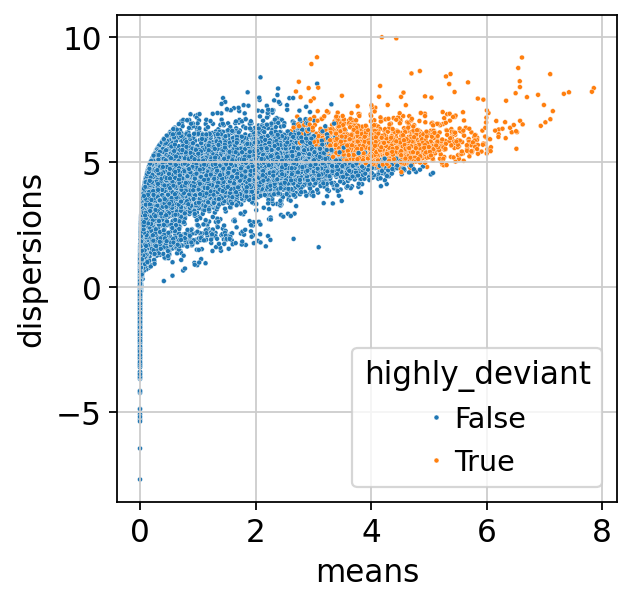

In [66]:
ax = sns.scatterplot(
    data=adata.var, x="means", y="dispersions", hue="highly_deviant", s=5
)

plt.show()

**Section 9: Dimensionality Reduction**

In [67]:
adata_copy = adata.copy()
adata_copy.X = adata.layers['log1p_norm']

In [68]:
# setting highly variable as highly deviant to use scanpy 'use_highly_variable' argument in sc.pp.pca
adata_copy.var["highly_variable"] = adata_copy.var["highly_deviant"]
sc.pp.pca(adata_copy, svd_solver="arpack", use_highly_variable=True)

/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:385: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


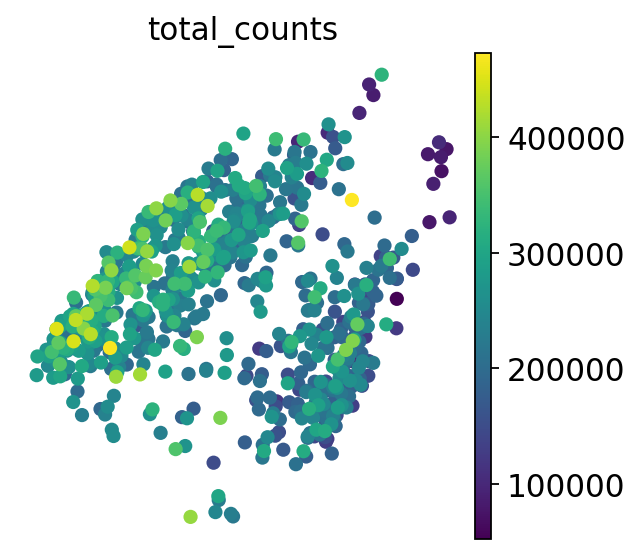

In [69]:
sc.pl.pca_scatter(adata_copy, color="total_counts")

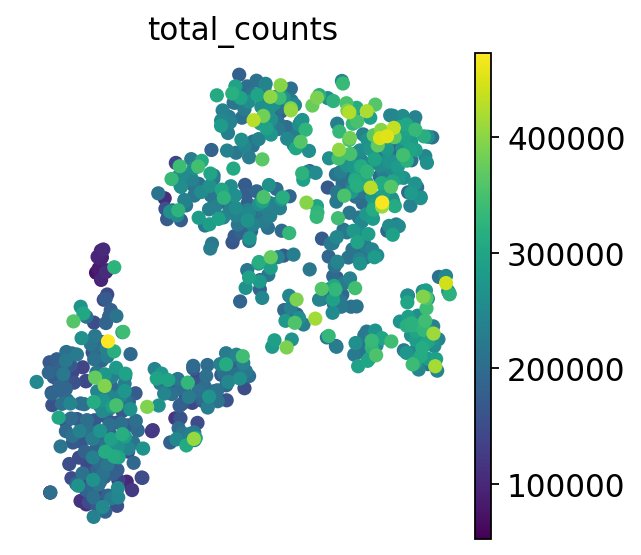

In [71]:
sc.tl.tsne(adata_copy, use_rep="X_pca")
sc.pl.tsne(adata_copy, color="total_counts")

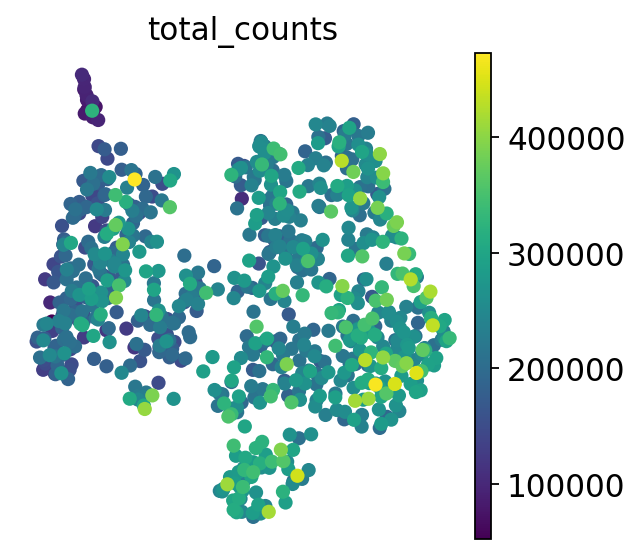

In [73]:
sc.pp.neighbors(adata_copy)
sc.tl.umap(adata_copy)
sc.pl.umap(adata_copy, color="total_counts")